<a href="https://colab.research.google.com/github/pachterlab/CP_2022/blob/main/notebooks/densityAnalysis/uteroDensityAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Read in files from NCBI GEO
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv.gz

!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz
!wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz

#integrated.scaled.assay105

In [2]:
!gunzip *.gz

In [3]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 145 (delta 3), reused 2 (delta 2), pack-reused 137
Receiving objects: 100% (145/145), 419.61 KiB | 8.39 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [4]:
%cd /content/densvis/densne/

/content/densvis/densne


In [5]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [6]:
%cd /content/

/content


In [7]:
!git clone https://github.com/pachterlab/CP_2022.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 718, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 718 (delta 162), reused 247 (delta 136), pack-reused 424
Receiving objects: 100% (718/718), 272.26 MiB | 23.35 MiB/s, done.
Resolving deltas: 100% (375/375), done.
Checking out files: 100% (81/81), done.


In [8]:
%cd /content/CP_2022/scripts

/content/CP_2022/scripts


In [9]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

     |████████████████████████████████| 96 kB 2.8 MB/s 
     |████████████████████████████████| 7.7 MB 4.8 MB/s 
     |████████████████████████████████| 88 kB 7.4 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 1.1 MB 59.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


## **Install Packages**

In [10]:
import statistics
import anndata 
import pandas as pd
import numpy as np

from Picasso import Picasso
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')


## **Analysis of E8.5 Data**

In [11]:
# General parameters
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1


ndims = 2

data_path = '/content'

n_latent = 50
pcs = 15
pcs2 = 15

In [12]:
def readLgMat(fname, data_path='/content'):

  col_names = pd.read_csv(data_path+fname, nrows=0).columns
  types_dict = {'Unnamed: 0': str}
  types_dict.update({col: np.float16 for col in col_names if col not in types_dict})

  chunk = pd.read_csv(data_path+fname,chunksize=1000,index_col=0,dtype=types_dict)
  counts = pd.concat(chunk)

  return counts

Read in Seurat-Integrated, Normalized counts

In [13]:
counts = pd.read_csv(data_path+'/GSE149372_scRNA.normalized.assay85.csv',index_col=0)
print(counts.head())


cellMeta = pd.read_csv(data_path+'/GSE149372_scRNA.MetaData.85.csv')
print(cellMeta.head())

        AAACGAAAGTCCCGAC-1  AAACGAAGTCGAGTTT-1  AAACGCTAGGACTTCT-1  \
Xkr4              0.000000            0.000000            0.000000   
Rp1               0.000000            0.000000            0.597661   
Sox17             0.000000            0.000000            0.000000   
Mrpl15            1.175618            0.559627            0.597661   
Lypla1            0.751450            0.916306            0.597661   

        AAACGCTCAACGCCCA-1  AAACGCTTCTGTGCGG-1  AAACGCTTCTTCTAAC-1  \
Xkr4                   0.0            0.000000            0.000000   
Rp1                    0.0            0.000000            0.000000   
Sox17                  0.0            0.000000            0.000000   
Mrpl15                 0.0            1.487989            0.770525   
Lypla1                 0.0            0.000000            0.000000   

        AAAGAACGTCTACACA-1  AAAGAACTCGACGACC-1  AAAGGATCAGTTCTAG-1  \
Xkr4                   0.0                 0.0            0.000000   
Rp1               

In [14]:
#Center and scale log-normalized data
count_mat = counts.values.T

In [15]:
adata = anndata.AnnData(X = count_mat)
adata.obs_names = list(counts.columns)
adata.var_names = list(counts.index)
adata.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata.obs['Cluster'] = pd.Categorical(cellMeta.seurat_clusters)
adata

<ipython-input-15-5032faf166f1>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X = count_mat)


AnnData object with n_obs × n_vars = 10290 × 19588
    obs: 'Utero', 'Cluster'

In [16]:
exAdata = adata[adata.obs['Utero']=='ExUt']
inAdata = adata[adata.obs['Utero']=='InUt']
exAdata

View of AnnData object with n_obs × n_vars = 6205 × 19588
    obs: 'Utero', 'Cluster'

In [17]:
#In paper, use top 2000 HVGs and 15 PCs
def scaleAdata(adata):
  sc.pp.filter_cells(adata, min_counts=0)
  sc.pp.filter_genes(adata, min_counts=0)


  sc.pp.highly_variable_genes(adata,n_top_genes=2000)

  adata = adata[:,adata.var['highly_variable']]
  adata.obsm['log'] = adata.X

  sc.pp.scale(adata, max_value=10)
  return adata

In [18]:
adata = scaleAdata(adata)
exAdata = scaleAdata(exAdata)
inAdata = scaleAdata(inAdata)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:128: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  if min_genes is None and max_genes is None: adata.obs['n_counts'] = number


In [19]:
adata

AnnData object with n_obs × n_vars = 10290 × 1999
    obs: 'Utero', 'Cluster', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'log'

In [20]:
inAdata

AnnData object with n_obs × n_vars = 4085 × 2000
    obs: 'Utero', 'Cluster', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'log'

In [21]:
exAdata

AnnData object with n_obs × n_vars = 6205 × 2000
    obs: 'Utero', 'Cluster', 'n_counts'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg'
    obsm: 'log'

In [22]:
#From assignments in Fig.2 and Extended Data Fig. 8 c in Aguilera-Castrejon et al. 2021
cell_types = {'0': 'Blood', '1': 'Somitic Mesoderm', '2': 'Foregut Mid-hindgut', '3': 'Cardiac', '4': 'Mid-hindbrain',
'5': 'Endothelial', '6': 'Presomitic/Mixed Mesoderm', '7':'Amnion', '8':'Extra-Embryonic Endoderm', '9':'Pharyngeal Mesoderm',
'10': 'Extra-Embryonic Ectoderm', '11': 'Blood' , '12':'Placodes', '13': 'Neural Tube', '14':'Extra-Embryonic Mesoderm',
'15':'Amnion', '16':'Neural Tube', '17':'Amnion', '18':'Endothelial'}


cdict = {'Blood':'#70D4CE','Presomitic/Mixed Mesoderm':'#81A483','Foregut Mid-hindgut':'#4D50E3',
        'Cardiac':'#E0B7CF','Mid-hindbrain':'#FC514A','Endothelial':'#EDE7D1',
        'Amnion':'#B4CA72',
        'Extra-Embryonic Endoderm':'#C7A2F3','Pharyngeal Mesoderm':'#CCD0BC','Extra-Embryonic Ectoderm':'#73F0FD',
        'Placodes':'#AE995B','Neural Tube':'#87BD7E','Somitic Mesoderm':'#D34FEA',
        'Extra-Embryonic Mesoderm':'#0F5813'}


In [ ]:

# cell_types = {'0': 'Blood', '1': 'Mixed Mesoderm', '2': 'Foregut', '3': 'Cardiac', '4': 'Mid Hind Brain',
# '5': 'Endothelial', '6': 'Presomitic Mesoderm', '7':'Amnion', '8':'Extra-Embryonic Endoderm', '9':'Pharyngeal Mesoderm',
# '10': 'Extra-Embryonic Ectoderm', '11': 'Blood' , '12':'Placodes', '13': 'Neural Tube', '14':'Extra-Embryonic Mesoderm',
# '15':'Somitic Mesoderm', '16':'Neural Crest', '17':'Amnion', '18':'Mid Hind Gut'}

# cdict = {'Blood':'#70D4CE','Mixed Mesoderm':'#81A483','Foregut':'#4D50E3',
#         'Cardiac':'#E0B7CF','Mid Hind Brain':'#FC514A','Endothelial':'#EDE7D1',
#         'Presomitic Mesoderm':'#0F5813','Amnion':'#B4CA72',
#         'Extra-Embryonic Endoderm':'#C7A2F3','Pharyngeal Mesoderm':'#08C3B2','Extra-Embryonic Ectoderm':'#73F0FD',
#         'Placodes':'#AE995B','Neural Tube':'#87BD7E','Somitic Mesoderm':'#D34FEA',
#         'Neural Crest':'#CCD0BC','Mid Hind Gut':'#84BF82','Extra-Embryonic Mesoderm':'#8FD6BF'}


In [23]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

# select 42 colours from the "Reds" cmap
red_selection = cm.get_cmap("Reds", 42)
blue_selection = cm.get_cmap("Blues", 42)

# select half of the colours, closest to Red and assign to a new colormap
red_cmap = ListedColormap(red_selection(range(42))[11:, :])
blue_cmap = ListedColormap(blue_selection(range(42))[11:, :])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-24-742576596b48>:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


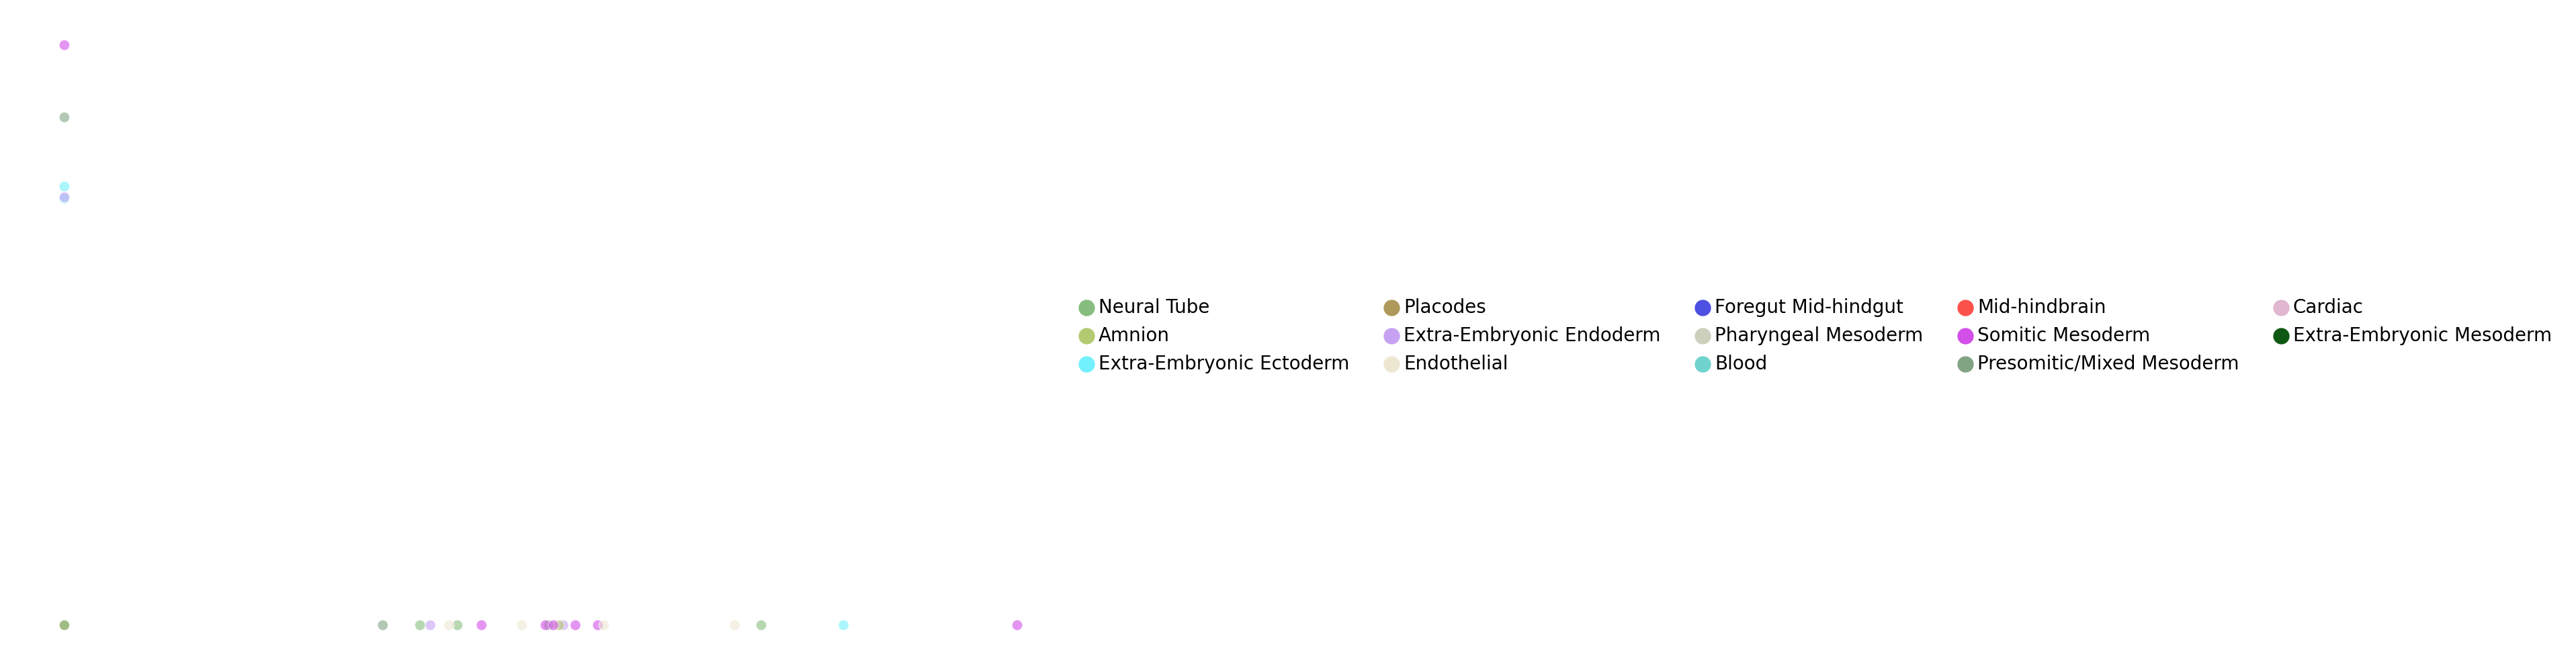

In [24]:
#Code to just make a legend with more columns

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(8,5))


x = count_mat[:,0]
y = count_mat[:,1]


labs = np.array([list(adata.obs['Cluster']),list(adata.obs['Utero'])])
fullNames = [cell_types[str(i)] for i in labs[0]]  

sns.scatterplot(x, y, s=20, alpha = 0.6,hue=list(pd.Categorical(fullNames)), palette = cdict) #label=list(cluster_label),

handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
ax.legend(handles, labels,loc='center left',bbox_to_anchor=(1, 0.5),prop={'size': 8},frameon=False,ncol=5)
ax.set_axis_off()

fig.tight_layout()
plt.savefig('legend.pdf')

### **Run UMAP/2D Embeddings** 

In [25]:
state = 41

In [26]:
#Looking at combined space
toUseAdata = adata
count_mat = toUseAdata.obsm['log']
scaled_mat = toUseAdata.X

In [27]:
labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

fullNames = [cell_types[str(i)] for i in labs[0]]
toUseAdata.obs['Cluster'] = pd.Categorical(fullNames)
colors = [cdict[i] for i in pd.unique(toUseAdata.obs['Cluster'])]

In [28]:
#PCA  + UMAP
tsvd = TruncatedSVD(n_components=50)
x_pca = tsvd.fit_transform(scaled_mat)

pcaUMAP = []
for n in [5,15,50,103]:
  reducer = umap.UMAP(n_components = ndims, random_state = state, n_neighbors=n)
  pcaUMAP += [reducer.fit_transform(x_pca)]


In [65]:
#PCA  + t-SNE
tsvd = TruncatedSVD(n_components=50)
x_pca = tsvd.fit_transform(scaled_mat)

pcaTSNE = []
for n in [5,15,50,103]:
  tsne = TSNE(n_components = ndims, random_state = state,perplexity=n) 
  pcaTSNE += [tsne.fit_transform(x_pca)]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default lea

In [70]:
pcaTSNE41 = pcaTSNE

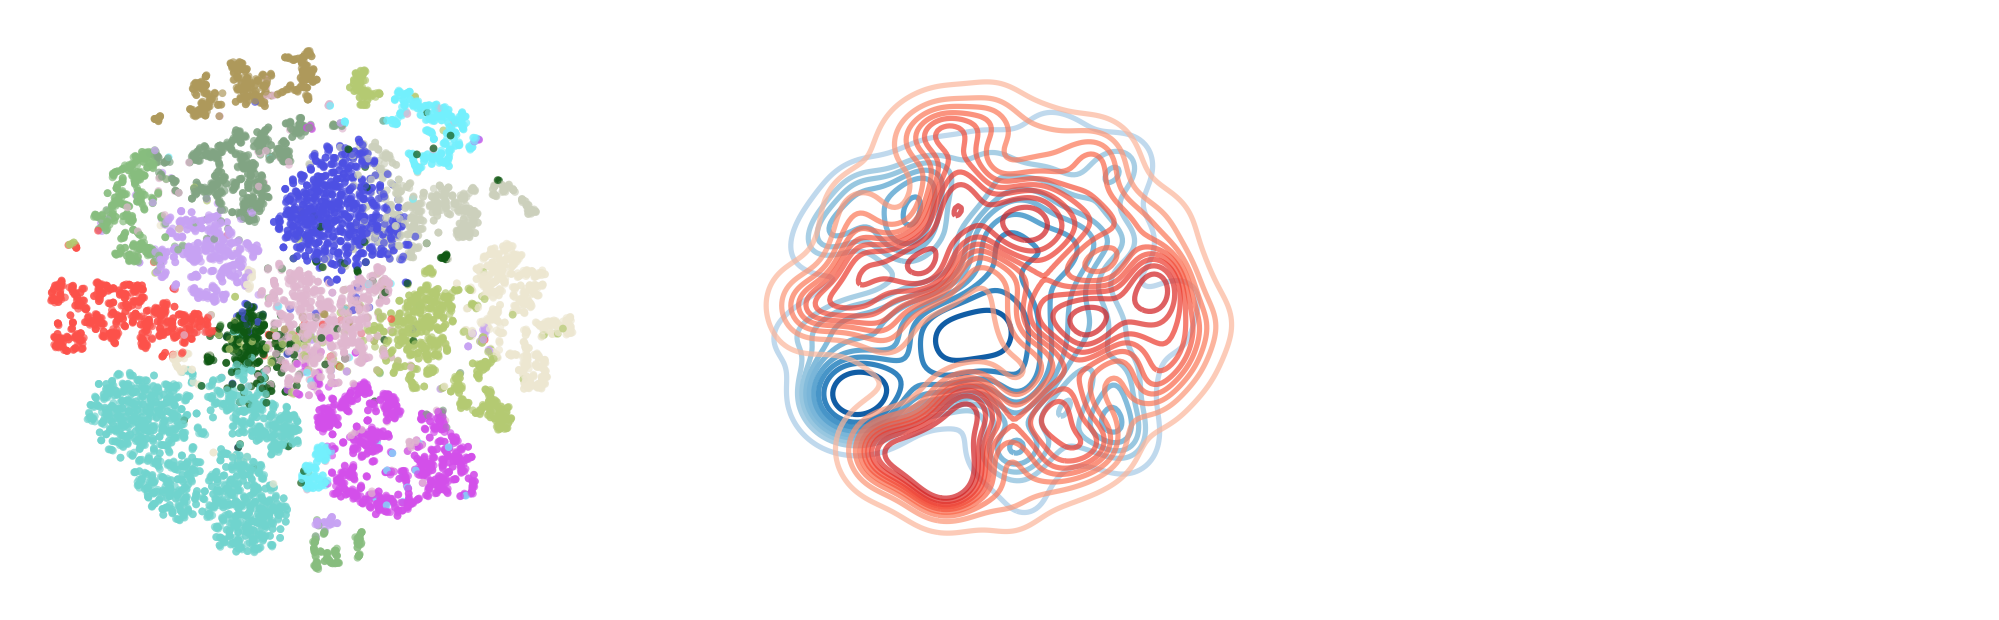

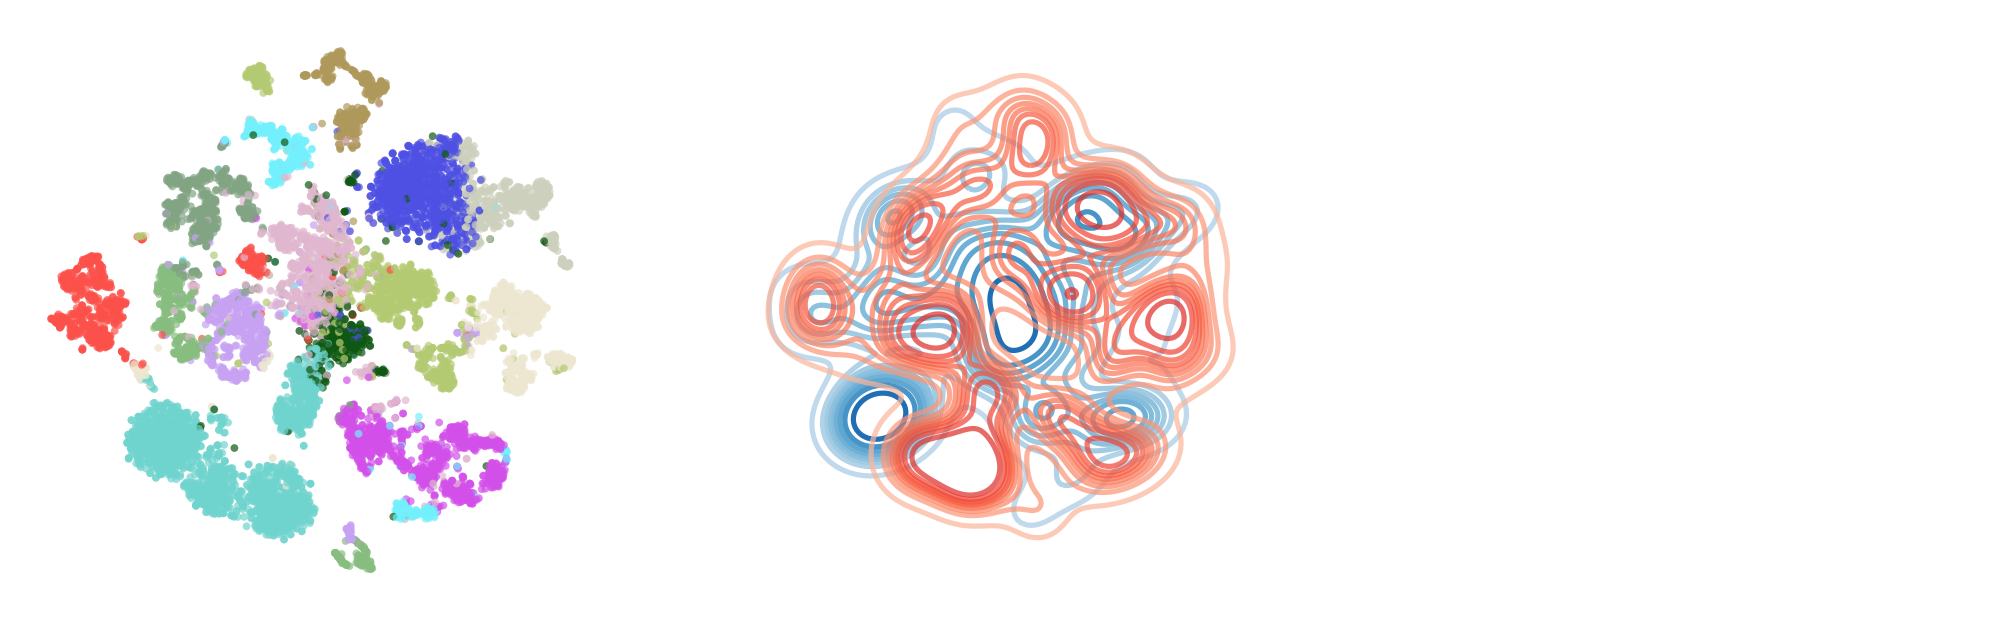

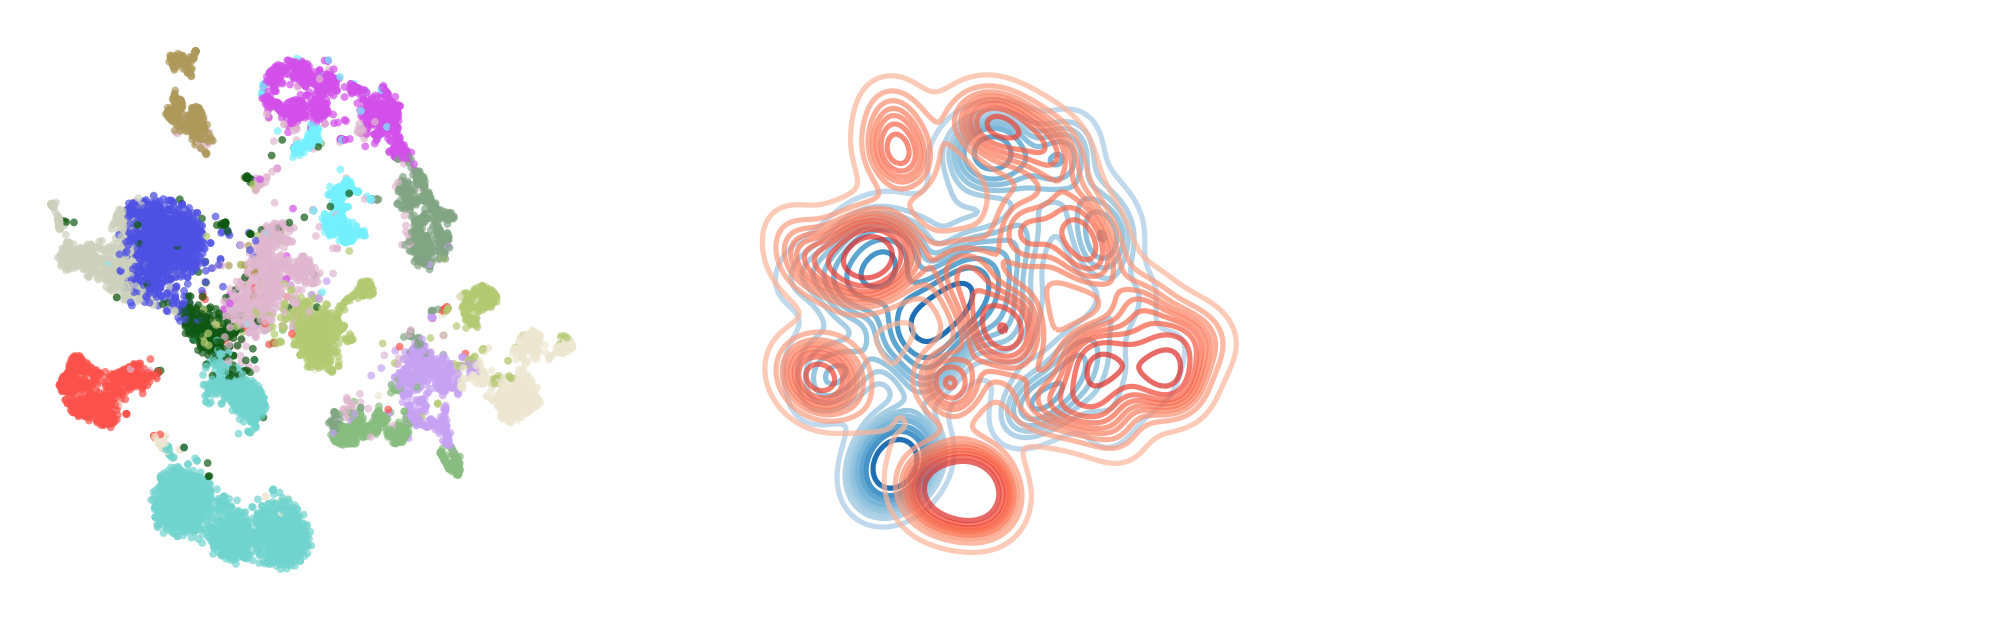

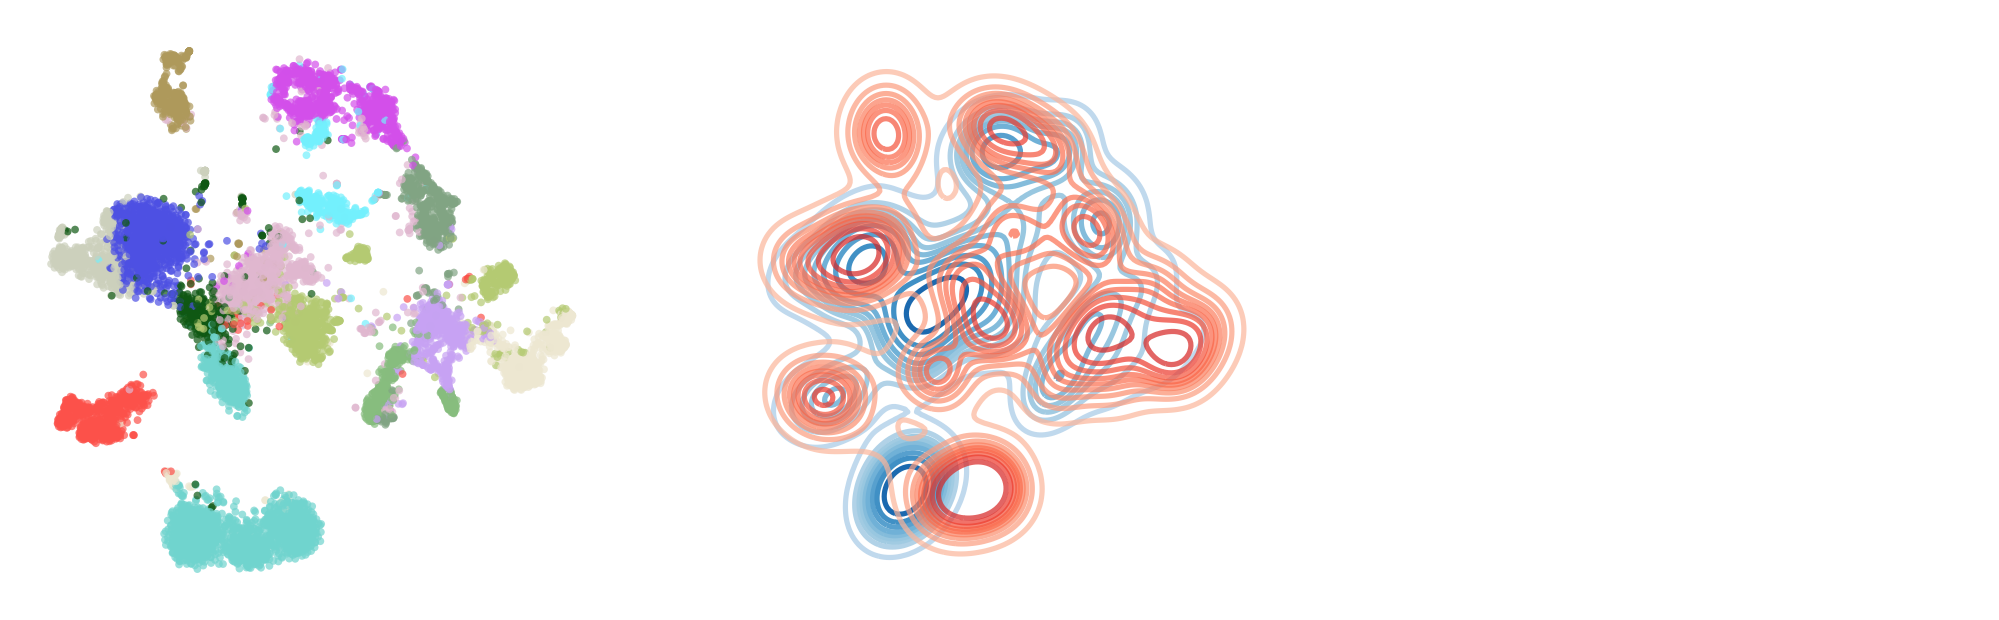

In [66]:
sns.set_style("white")
for i in pcaTSNE:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3))
  sns.scatterplot(x=i[:,0],y=i[:,1],hue=fullNames,palette=cdict,ax=ax1,legend=False,s=5,alpha=0.7,linewidth=0)
  sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1],cmap=blue_cmap,ax=ax2) #shade=True
  sns.kdeplot(x=i[labs[1]=='ExUt',0], y=i[labs[1]=='ExUt',1],  cmap=red_cmap,ax=ax2,alpha=0.7)
  #sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1], cmap="Blues", shade=True,ax=ax2) #bw_adjust=.5

  ax1.xaxis.set_ticklabels([])
  ax2.xaxis.set_ticklabels([])
  ax3.xaxis.set_ticklabels([])

  for ax in fig.axes:
    ax.grid(False)
    ax.axis("off")
    
  plt.show()

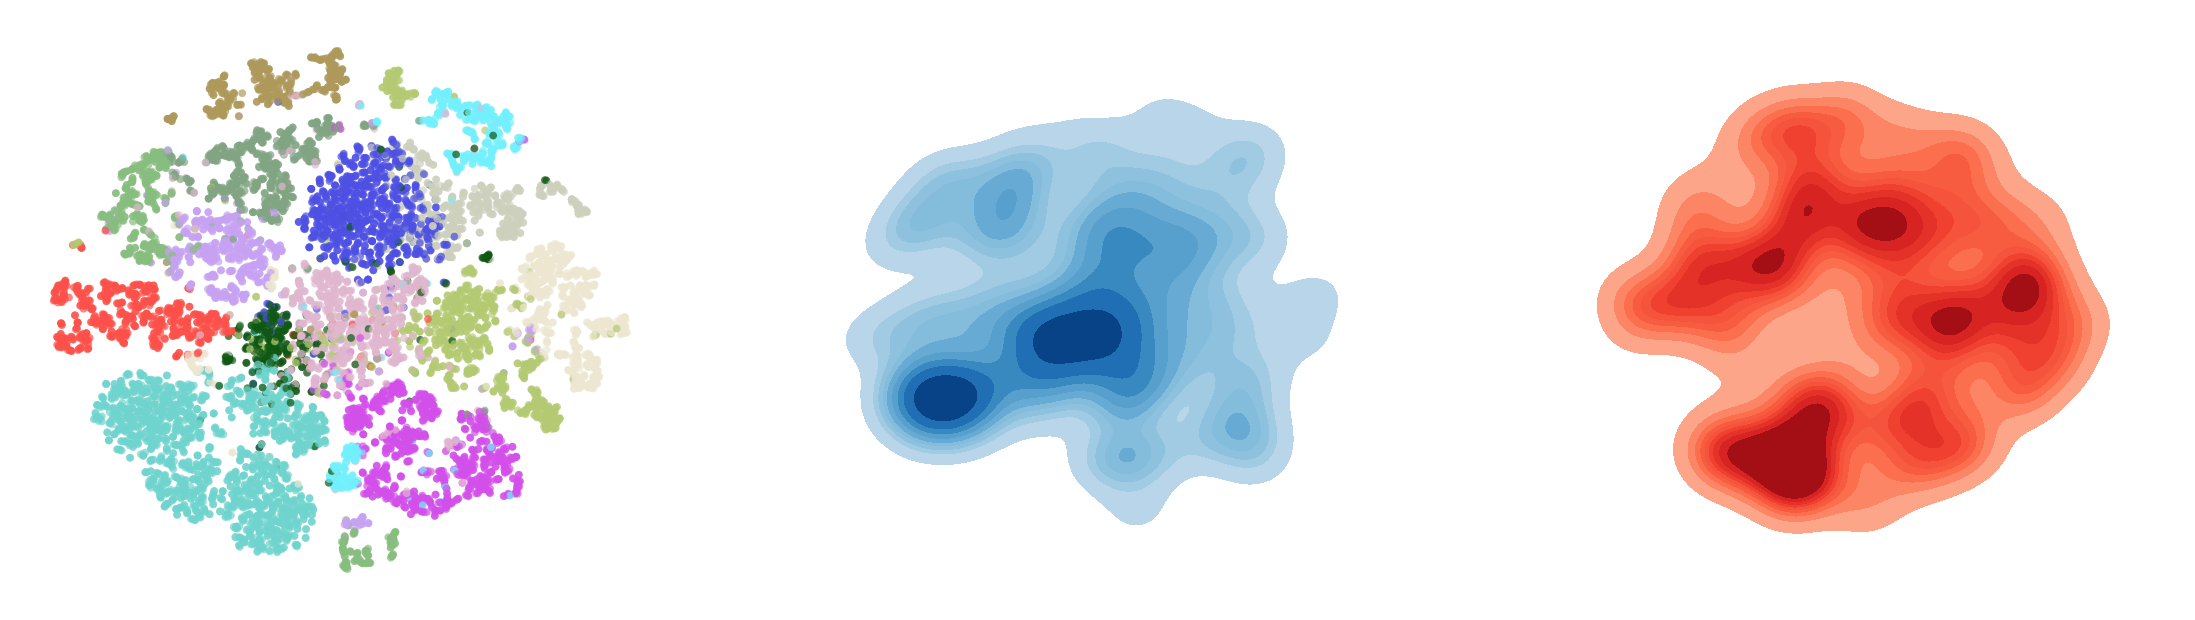

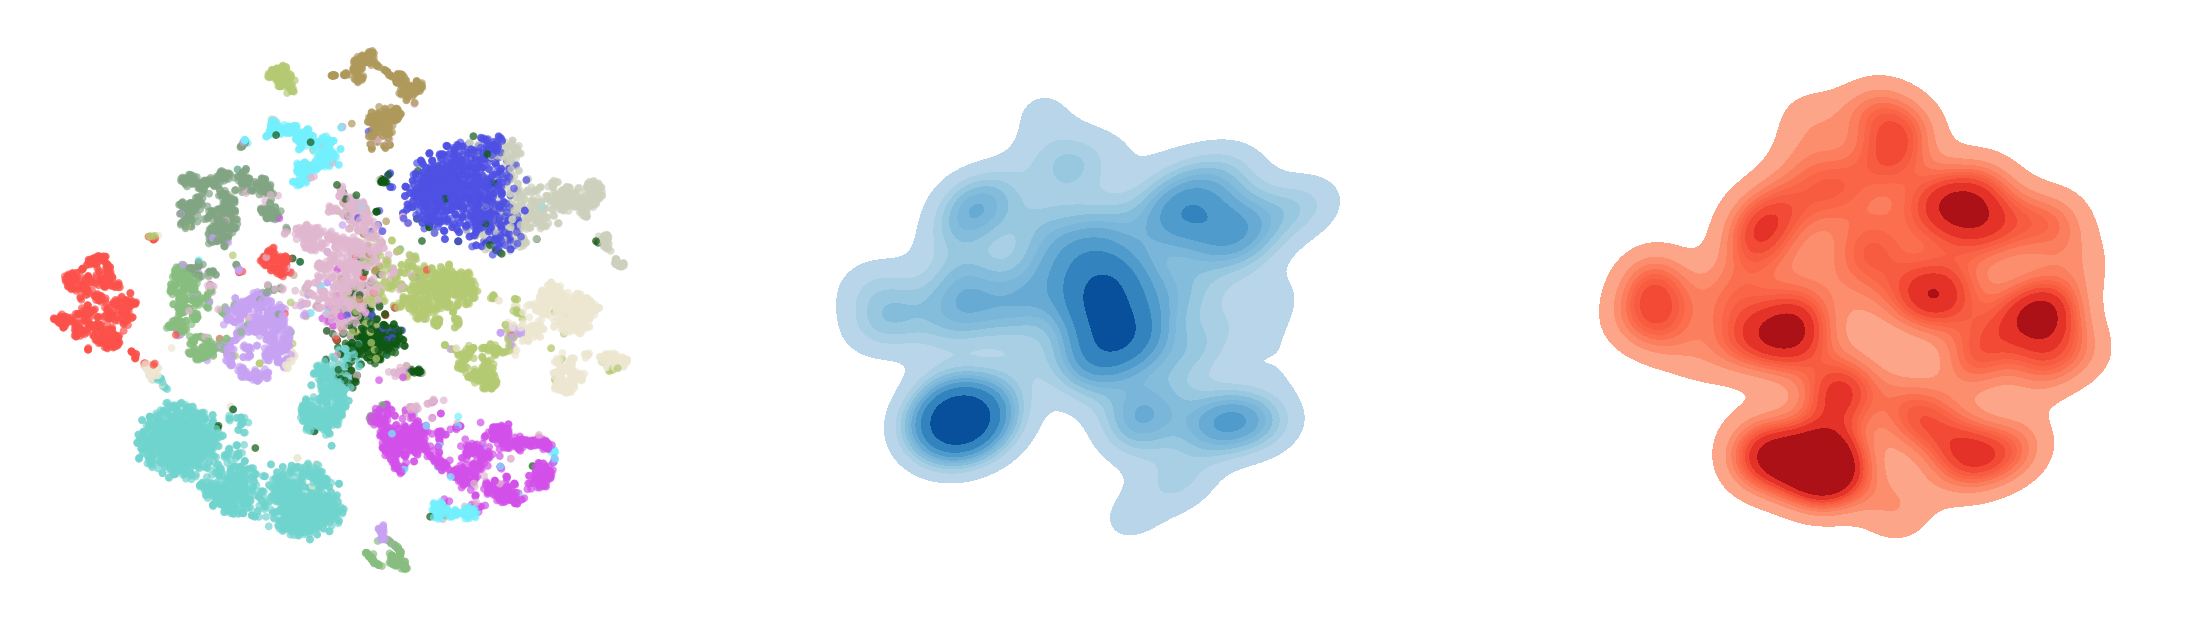

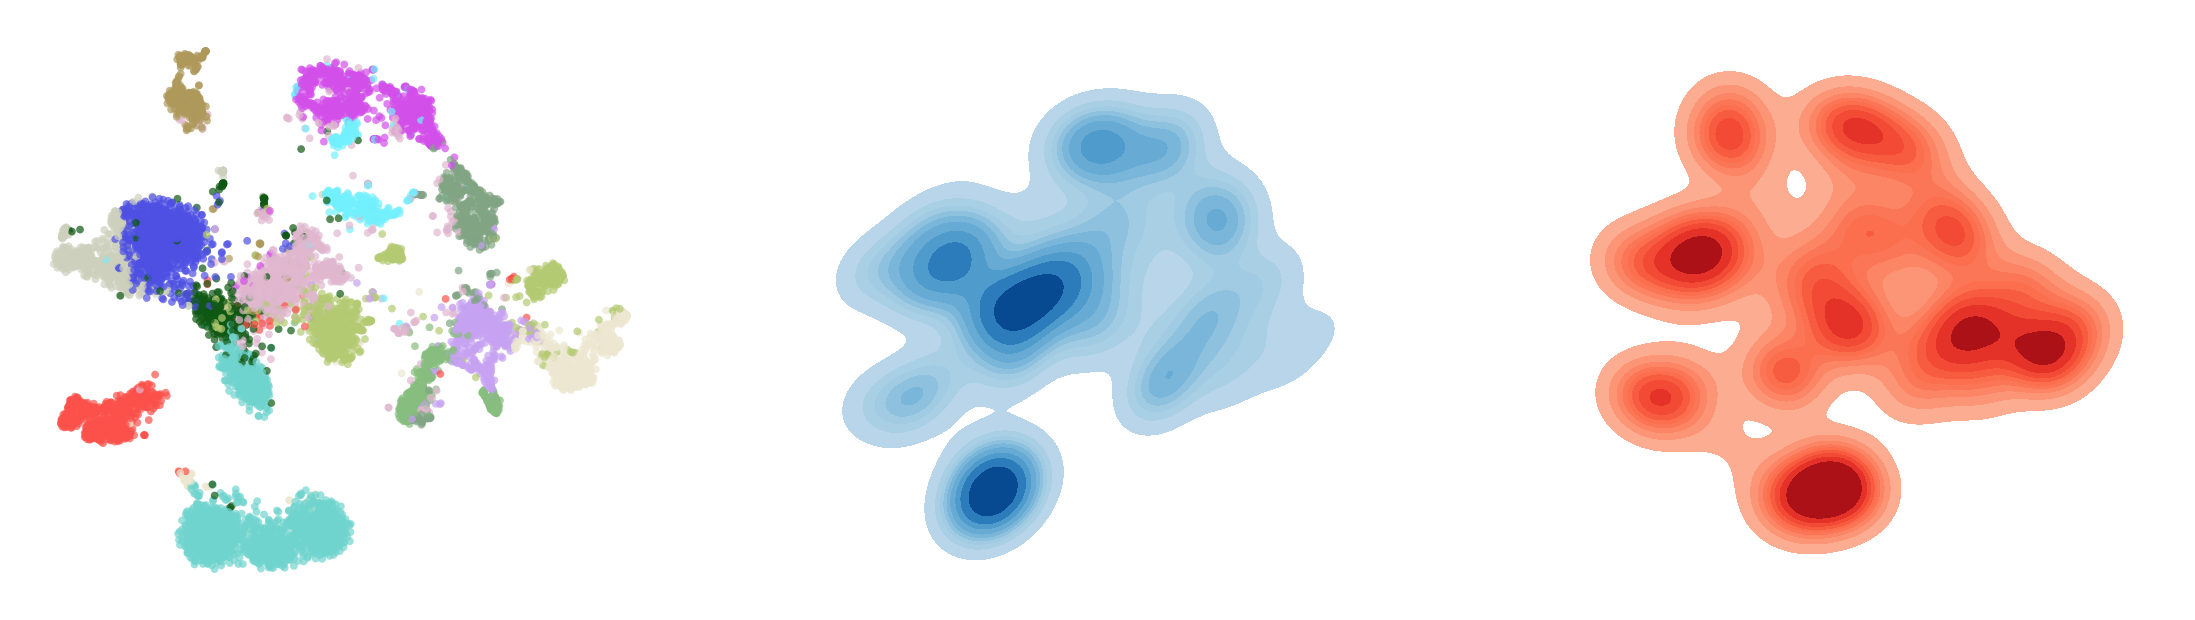

In [68]:
sns.set_style("white")
for i in pcaTSNE:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(11,3))
  sns.scatterplot(x=i[:,0],y=i[:,1],hue=fullNames,palette=cdict,ax=ax1,legend=False,s=5,alpha=0.7,linewidth=0)
  sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1],cmap=blue_cmap,ax=ax2,shade=True) #shade=True
  sns.kdeplot(x=i[labs[1]=='ExUt',0], y=i[labs[1]=='ExUt',1],  cmap=red_cmap,ax=ax3,shade=True)
  #sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1], cmap="Blues", shade=True,ax=ax2) #bw_adjust=.5

  ax1.xaxis.set_ticklabels([])
  ax2.xaxis.set_ticklabels([])
  ax3.xaxis.set_ticklabels([])

  for ax in fig.axes:
    ax.grid(False)
    ax.axis("off")

  plt.show()

In [103]:
pcaUMAP41 = pcaUMAP #saved loss of placodes

In [62]:
#13
#PCA  + UMAP
tsvd = TruncatedSVD(n_components=50)
x_pca = tsvd.fit_transform(scaled_mat)

pcaUMAP = []
for n in [5,15,50,103]:
  reducer = umap.UMAP(n_components = ndims, random_state = 41, n_neighbors=n)
  pcaUMAP += [reducer.fit_transform(x_pca)]


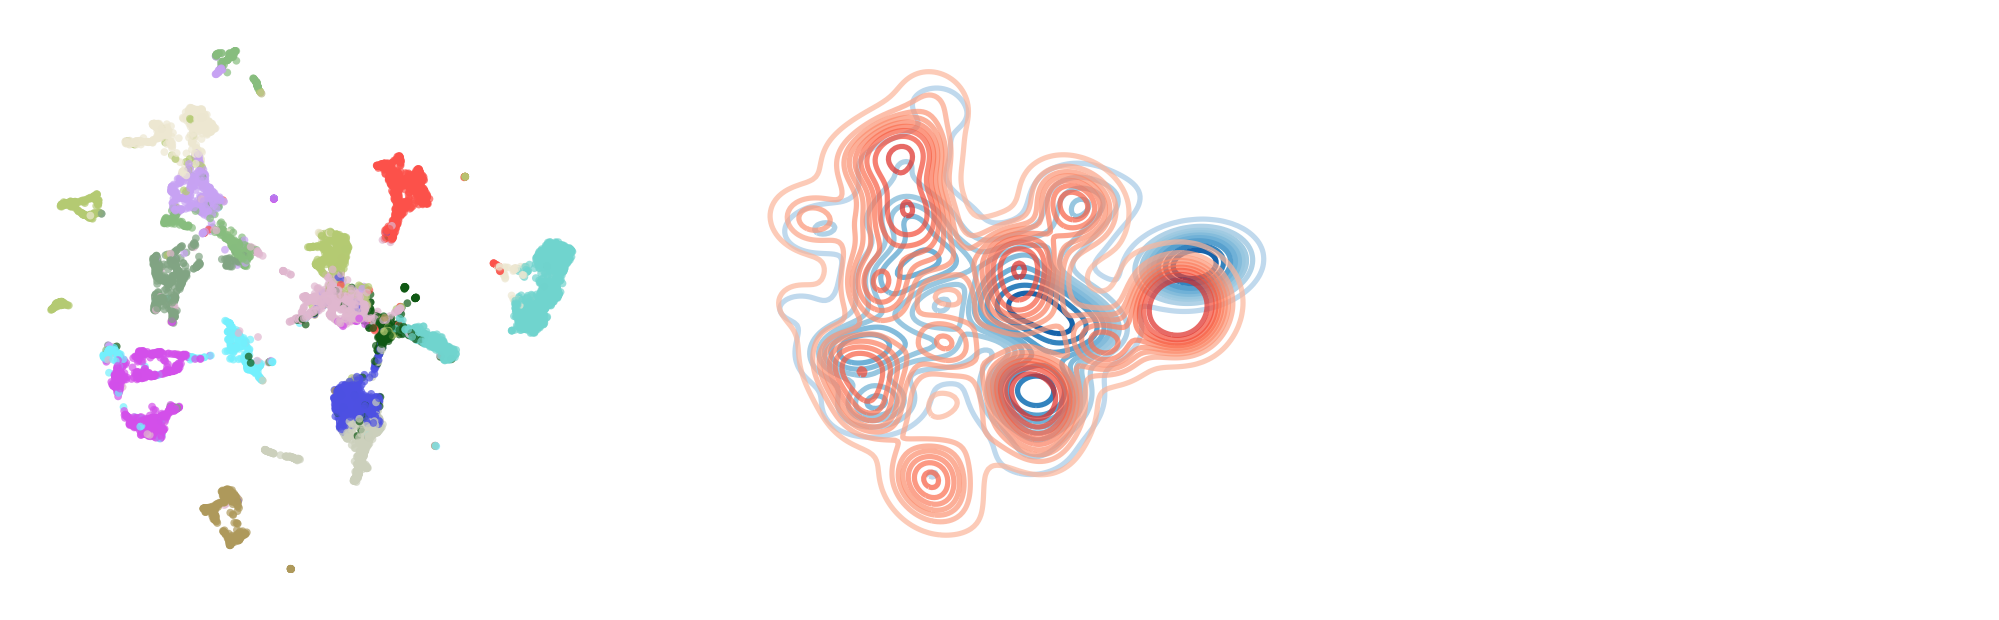

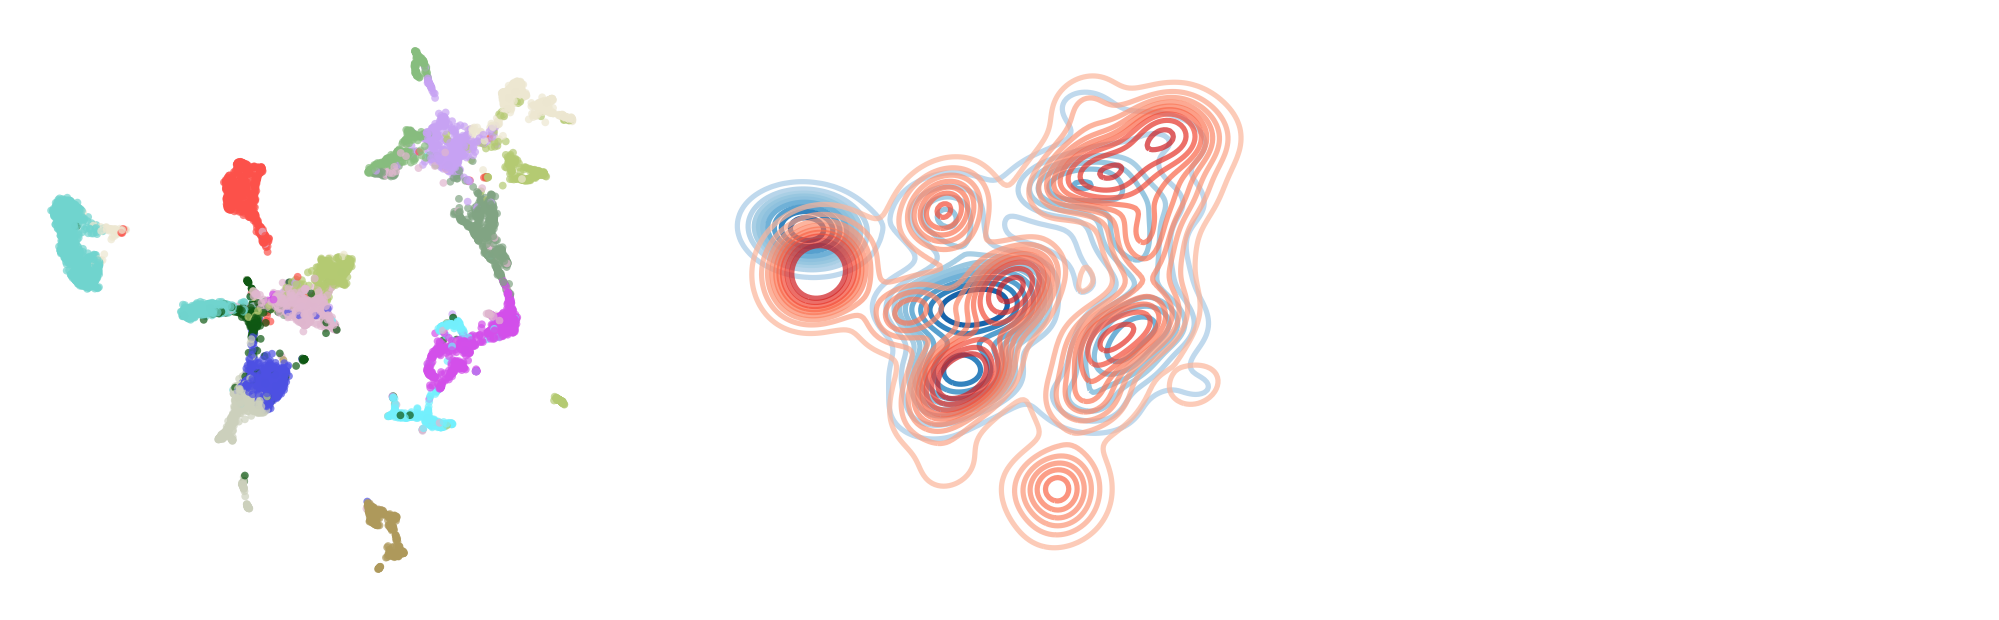

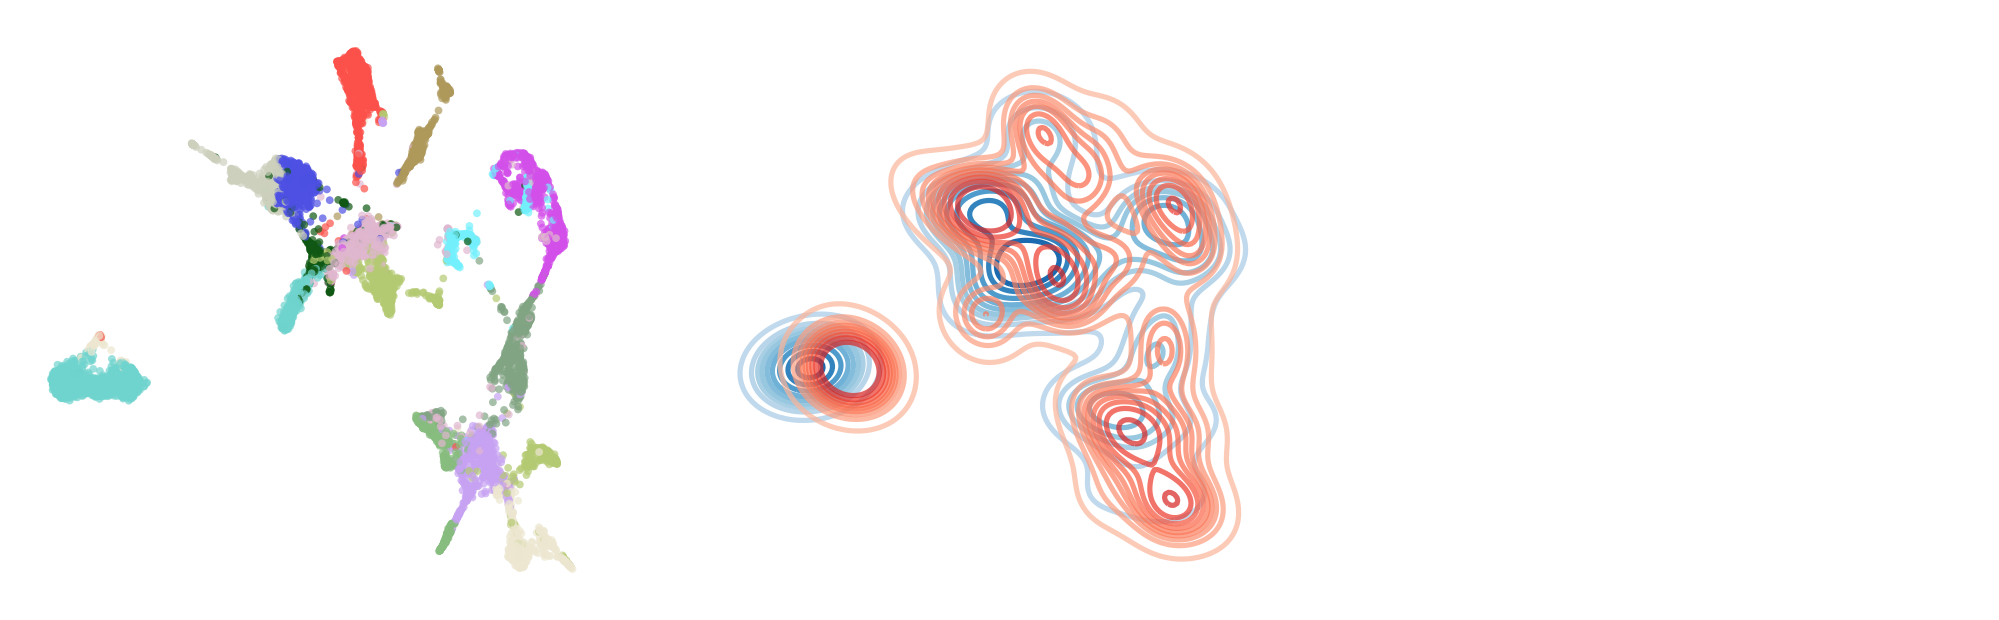

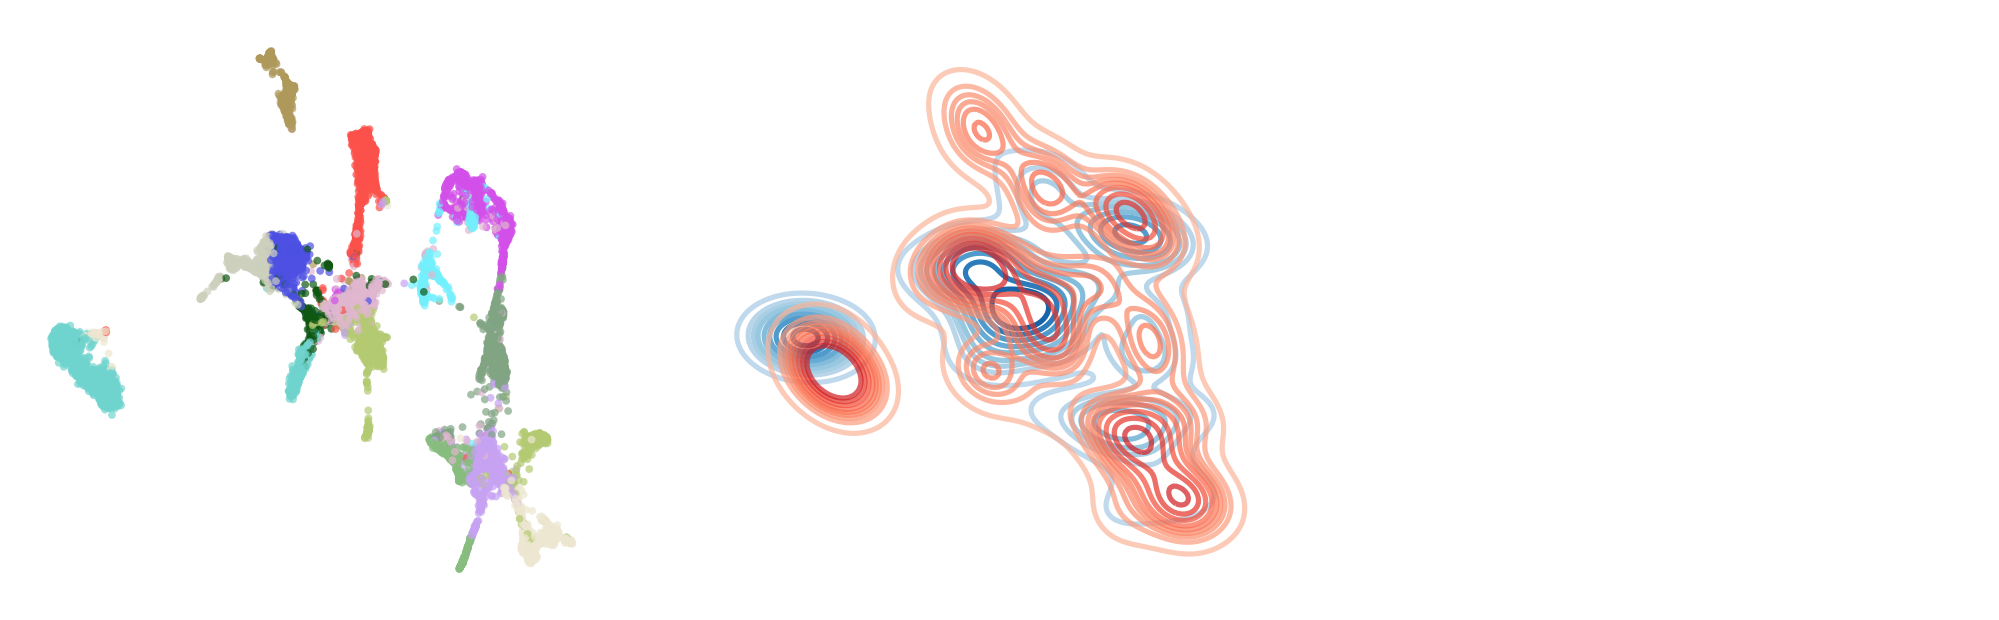

In [63]:
sns.set_style("white")
for i in pcaUMAP:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(10,3))
  sns.scatterplot(x=i[:,0],y=i[:,1],hue=fullNames,palette=cdict,ax=ax1,legend=False,s=5,alpha=0.7,linewidth=0)
  sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1],cmap=blue_cmap,ax=ax2) #shade=True
  sns.kdeplot(x=i[labs[1]=='ExUt',0], y=i[labs[1]=='ExUt',1],  cmap=red_cmap,ax=ax2,alpha=0.7)
  #sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1], cmap="Blues", shade=True,ax=ax2) #bw_adjust=.5

  ax1.xaxis.set_ticklabels([])
  ax2.xaxis.set_ticklabels([])
  ax3.xaxis.set_ticklabels([])
  for ax in fig.axes:
    ax.grid(False)
    ax.axis("off")
  plt.show()

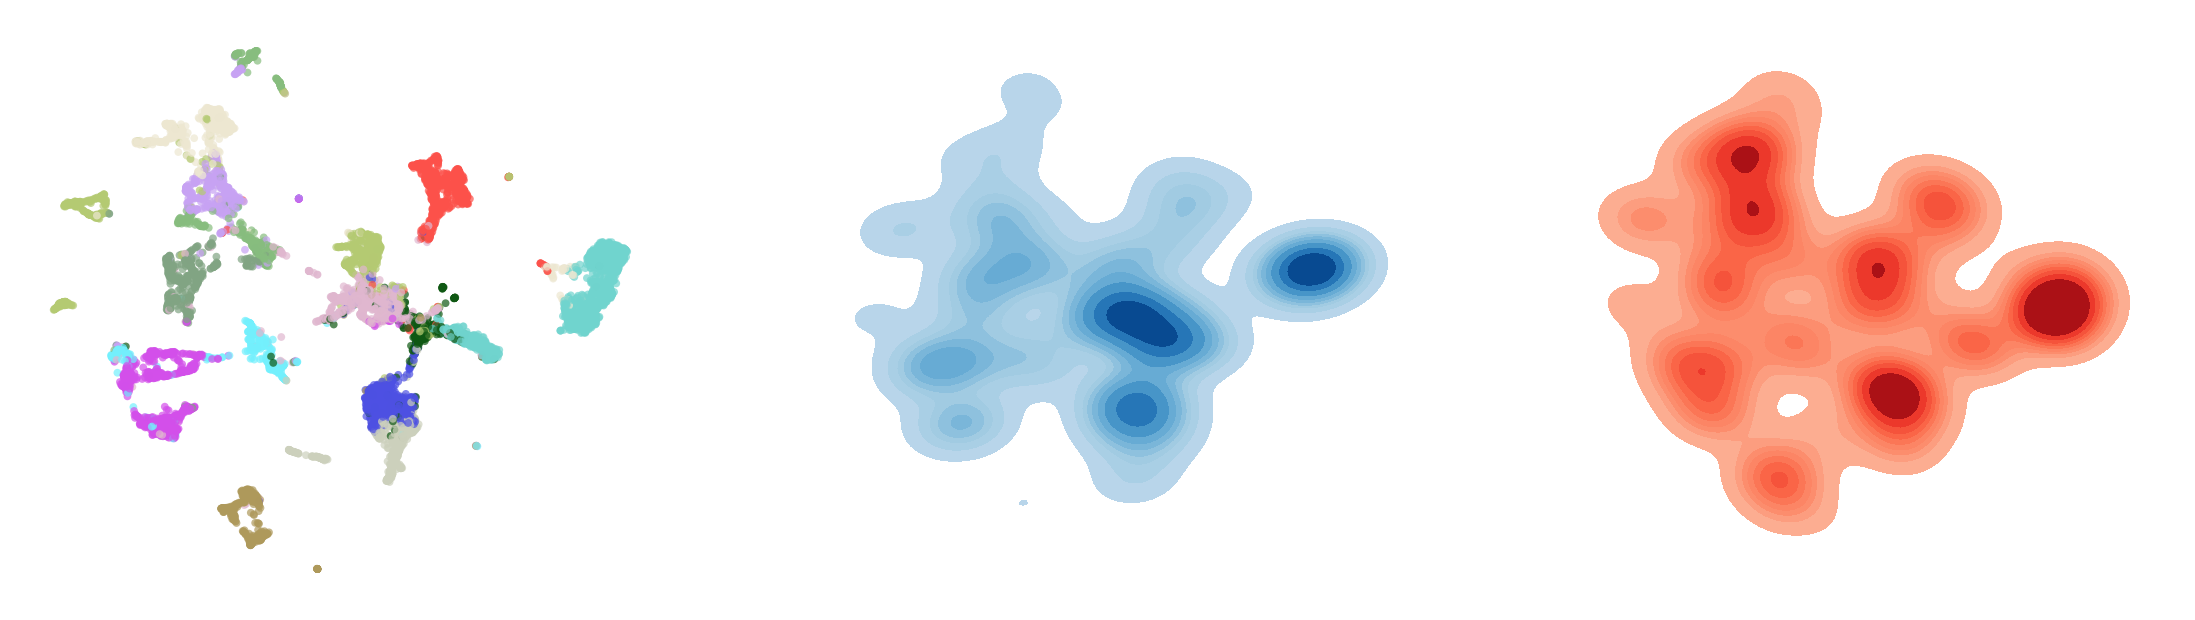

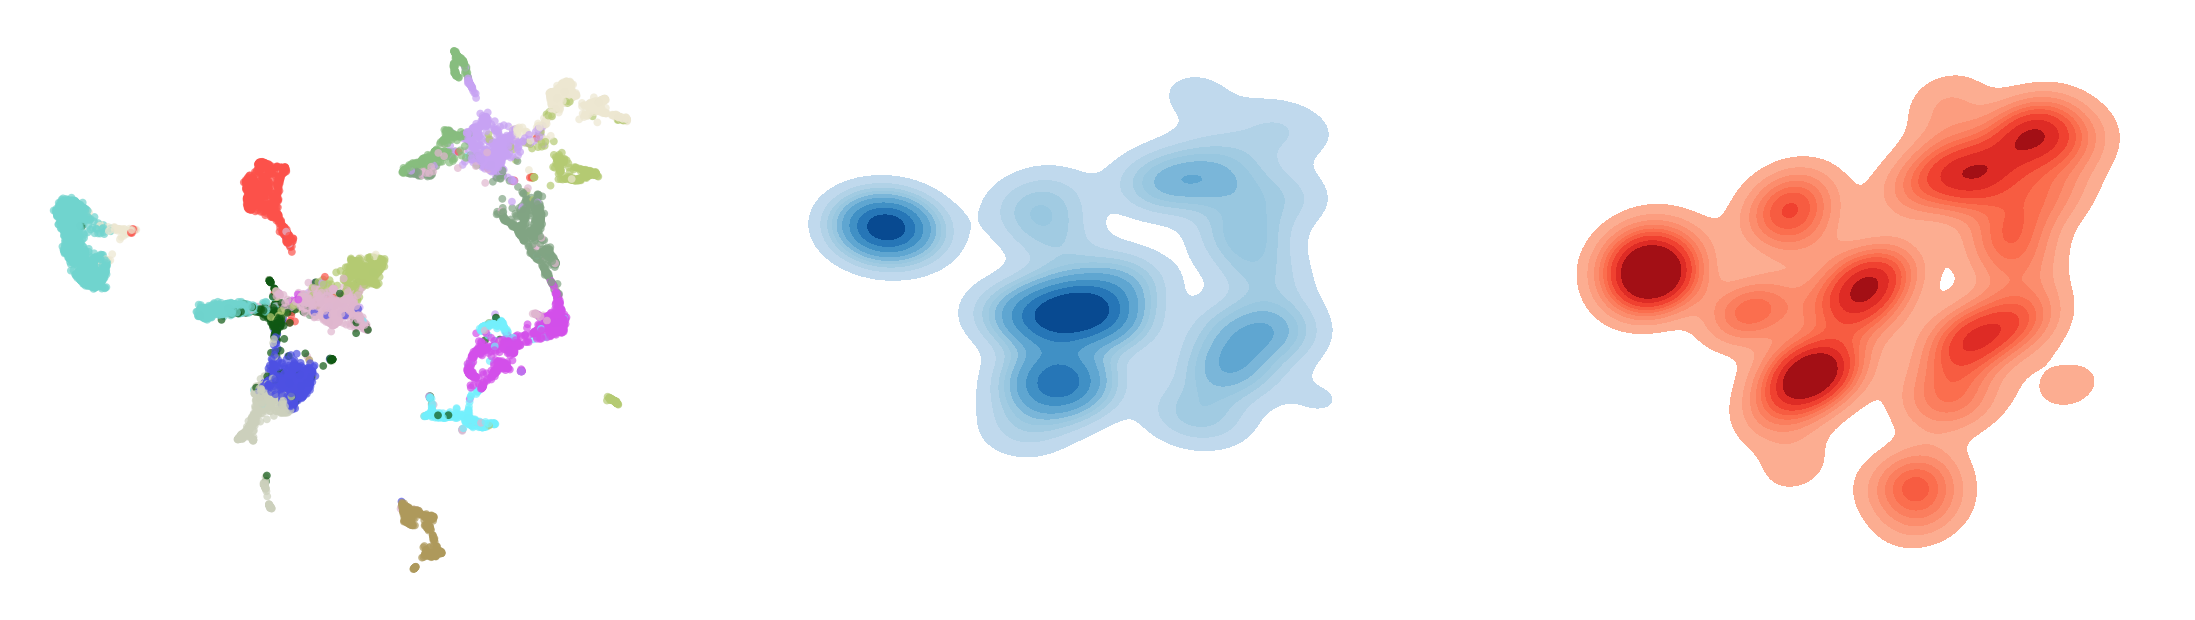

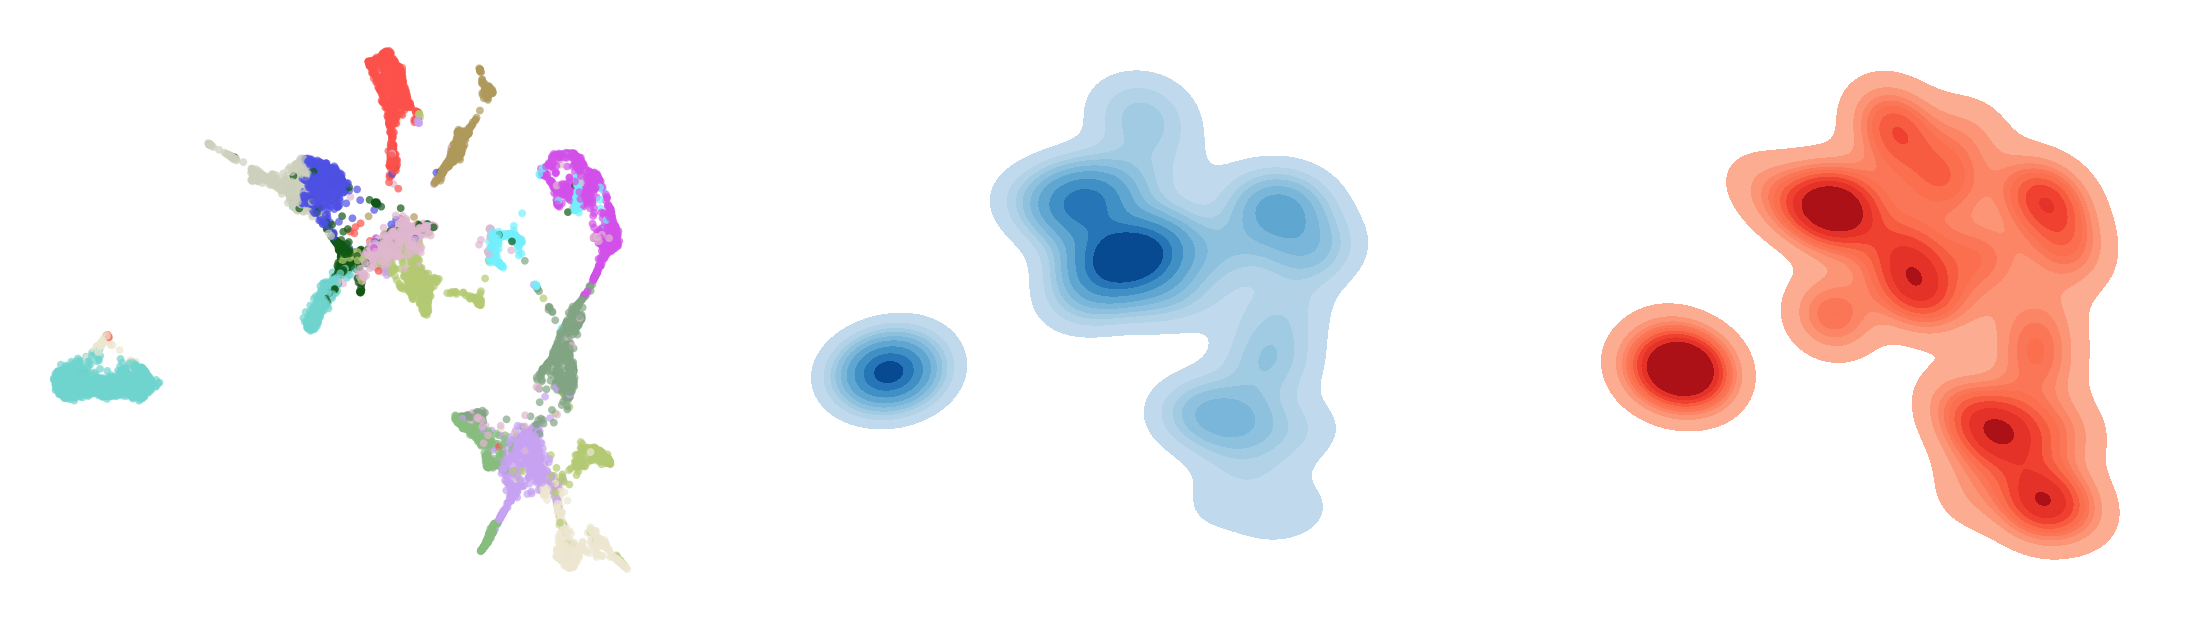

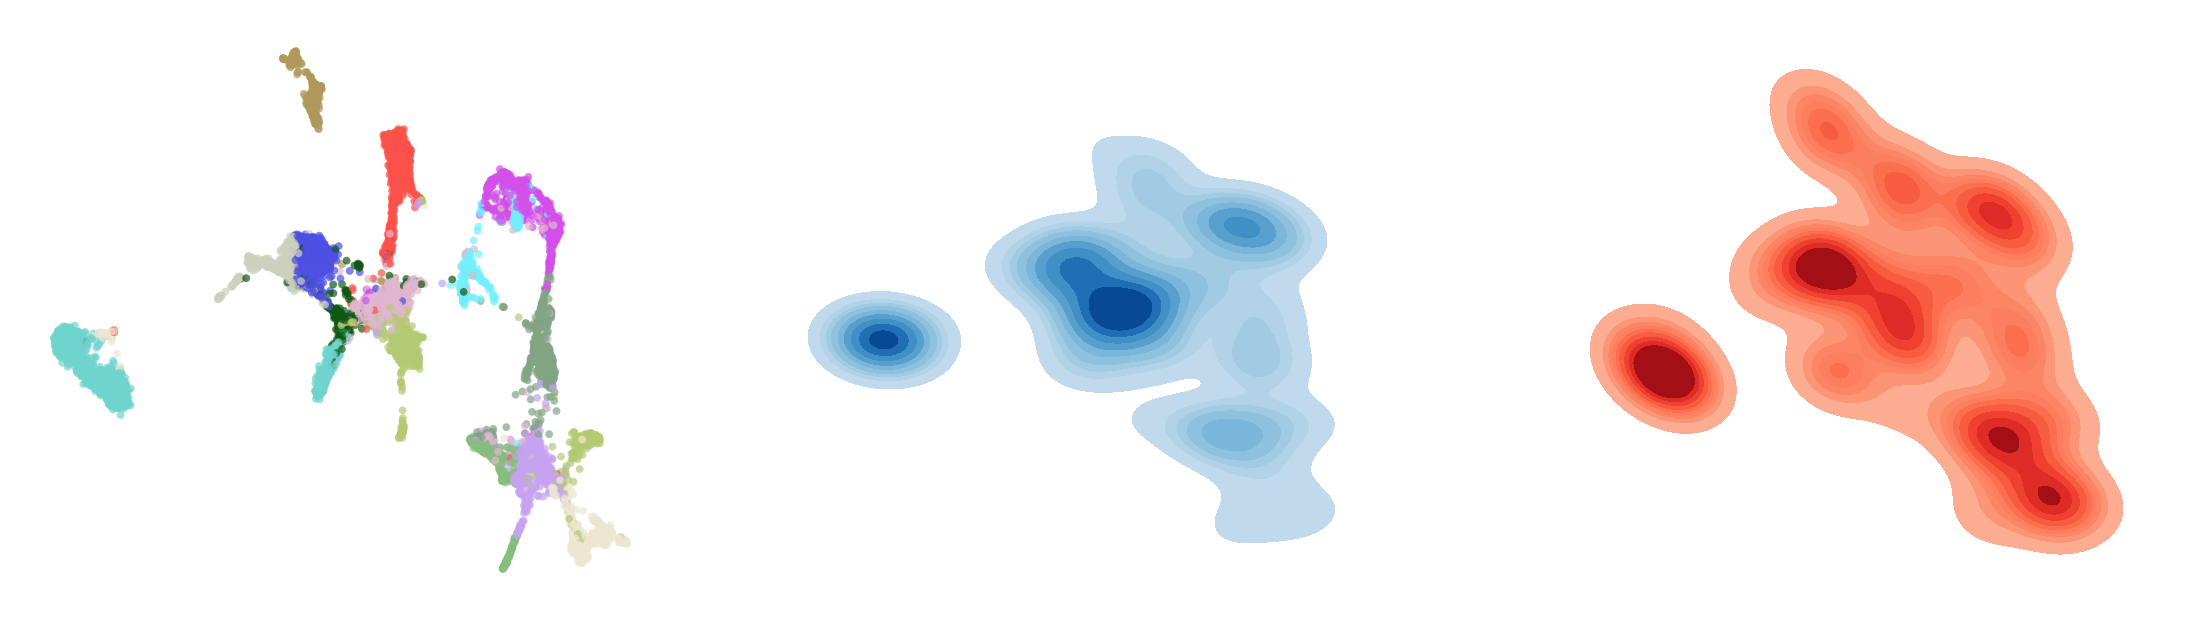

In [64]:
sns.set_style("white")
for i in pcaUMAP:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(11,3))
  sns.scatterplot(x=i[:,0],y=i[:,1],hue=fullNames,palette=cdict,ax=ax1,legend=False,s=5,alpha=0.7,linewidth=0)
  sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1],cmap=blue_cmap,ax=ax2,shade=True) #shade=True
  sns.kdeplot(x=i[labs[1]=='ExUt',0], y=i[labs[1]=='ExUt',1],  cmap=red_cmap,ax=ax3,shade=True)
  #sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1], cmap="Blues", shade=True,ax=ax2) #bw_adjust=.5

  ax1.xaxis.set_ticklabels([])
  ax2.xaxis.set_ticklabels([])
  ax3.xaxis.set_ticklabels([])

  for ax in fig.axes:
    ax.grid(False)
    ax.axis("off")
  plt.show()

## **Analysis of E10.5 Data**

In [ ]:
counts = readLgMat('/GSE149372_GSM5068636-GSM5068641_scRNA.integrated.scaled.assay105.csv',data_path=data_path)
counts.head()

AAACCCAAGCCTCACG-1  AAACCCAAGCTCGACC-1  AAACCCAAGTTAACAG-1  \
Hba-a1            -0.366699           -0.303711           -0.294678   
Hbb-bh1           -0.391846           -0.164429           -0.295654   
Hba-x              0.409912           -0.145752           -0.494385   
Gfod2             -0.947266           -0.459229           -0.254395   
Mt1               -0.296143           -0.667480           -0.426270   

         AAACCCACACCATATG-1  AAACCCAGTCACGCTG-1  AAACCCAGTGCGTTTA-1  \
Hba-a1             2.830078            3.193359           -0.350342   
Hbb-bh1            2.917969            3.232422           -0.368408   
Hba-x              2.945312            3.166016           -0.245972   
Gfod2             -0.182373            0.062988            0.299316   
Mt1                1.979492            1.252930           -0.436035   

         AAACCCAGTGGCTCTG-1  AAACCCATCCCATAGA-1  AAACGAAAGAAGCTCG-1  \
Hba-a1             2.978516           -0.426758           -0.448486   
Hbb-bh1            2.914062           -0.369385           -0.449463   
Hba-x              2.966797           -0.169556           -0.375977   
Gfod2              0.217407           -0.358154           -0.587402   
Mt1                2.855469            0.118347           -0.274170   

         AAACGAAAGACTAAGT-1  ...  TTTGGAGTCCCGAGTG-12  TTTGGTTAGTCTAACC-12  \
Hba-a1            -0.161011  ...            -0.313965            -0.265381   
Hbb-bh1           -0.322998  ...            -0.771973            -0.245239   
Hba-x             -0.462646  ...            -0.627441            -0.453369   
Gfod2             -0.140625  ...             0.168213            -0.163818   
Mt1                1.331055  ...            -0.440186            -0.308594   

         TTTGGTTCACAAAGCG-12  TTTGGTTGTATGAGGC-12  TTTGGTTTCGTGGCTG-12  \
Hba-a1             -0.435791            -0.354004            -0.579102   
Hbb-bh1            -0.029694            -0.744141            -0.196533   
Hba-x              -0.015388            -0.108826             0.317627   
Gfod2               3.056641            -0.401123             1.704102   
Mt1                -0.475098            -0.369385            -0.430664   

         TTTGTTGAGCAGCGAT-12  TTTGTTGCAGTCCGTG-12  TTTGTTGCAGTTCACA-12  \
Hba-a1             -0.314209             2.933594            -0.290771   
Hbb-bh1            -0.491455             2.970703             0.188110   
Hba-x              -0.010666             2.923828            -0.601562   
Gfod2              -0.355225            -0.213501            -0.847656   
Mt1                -0.371094             2.318359            -0.437744   

         TTTGTTGGTCGTGTTA-12  TTTGTTGTCCAACCAA-12  
Hba-a1             -0.413330            -0.441895  
Hbb-bh1            -0.280029            -0.370117  
Hba-x              -0.346924             0.152100  
Gfod2               0.135742             1.581055  
Mt1                -0.575684            -0.642090  

[5 rows x 56528 columns]

In [ ]:
cellMeta = pd.read_csv(data_path+'/GSE149372_GSM5068636-GSM5068641_scRNA.MetaData.105.csv')
print(cellMeta.head())

           Unnamed: 0 orig.ident  nCount_RNA  nFeature_RNA  samples Utero  \
0  AAACCCAAGCCTCACG-1      p10.5        4451          2028        1  ExUt   
1  AAACCCAAGCTCGACC-1      p10.5        8096          2793        1  ExUt   
2  AAACCCAAGTTAACAG-1      p10.5        6994          2760        1  ExUt   
3  AAACCCACACCATATG-1      p10.5       19467          3424        1  ExUt   
4  AAACCCAGTCACGCTG-1      p10.5        8205          1481        1  ExUt   

   percent.mt  integrated_snn_res.0.3  
0    5.526848                       7  
1    4.088439                       5  
2    3.345725                       5  
3    4.166025                       3  
4    1.962218                       3  


In [ ]:
counts2_orig = readLgMat('/GSE149372_GSM5068636-GSM5068641_scRNA.normalized.assay105.csv',data_path=data_path)
counts2 = counts2_orig.loc[list(counts.index)]
counts2.shape

(2000, 56528)

In [ ]:
#Center and scale log-normalized data
count_mat_orig = counts2.values.T

In [ ]:
adata2 = anndata.AnnData(X = count_mat_orig)
adata2.obs_names = list(counts2.columns)
adata2.var_names = list(counts2.index)
adata2.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata2.obs['Cluster'] = pd.Categorical(cellMeta['integrated_snn_res.0.3'])
adata2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 56528 × 2000
    obs: 'Utero', 'Cluster'

In [ ]:
cell_types = {'0': 'Radial glia', '1': 'Jaw & tooth progenitors', '2': 'Osteoblasts', '3': 'Erythroid lineage', '4': 'Chondrocytes and osteoblasts',
'5': 'Radial glia', '6': 'Epithelial cells', '7':'Neural progenitor cells', '8':'Chondrocytes and osteoblasts', '9':'Osteoblasts',
'10': 'Primitive erythroid lineage', '11': 'Schwann cell precursors' , '12':'White blood cells', '13': 'Cholinergic neurons', '14':'White blood cells',
'15':'Notochord cells', '16':'Myocytes', '17':'Limb mesenchyme', '18':'Erythroid lineage','19':'Hepatocytes'}

fullNames = [cell_types[str(i)] for i in adata2.obs['Cluster']]
adata2.obs['Cluster'] = pd.Categorical(fullNames)

In [ ]:
cdict = {'Neural progenitor cells':'#863FC4','Radial glia':'#A9F6F9','Erythroid lineage':'#AA8CD0',
        'Osteoblasts':'#D0C84A','Hepatocytes':'#5AAB60','Epithelial cells':'#F78AC1',
        'Chondrocytes and osteoblasts':'#AE47B9','Jaw & tooth progenitors':'#3C8163',
        'Primitive erythroid lineage':'#EF51B8','White blood cells':'#E1FF4F','Cholinergic neurons':'#6BB07A',
        'Schwann cell precursors':'#BD7EB1','Myocytes':'#E261DC','Notochord cells':'#F5BEAA',
        'Limb mesenchyme':'#6AEC6C'}


In [ ]:
adata2.obsm['log'] = adata2.X #Data matrix is log-normalized 

adata2.raw = adata2.copy()


In [ ]:
inAdata = adata2[adata2.obs['Utero'].isin(["InUt"])]
inAdata

View of AnnData object with n_obs × n_vars = 21546 × 2000
    obs: 'Utero', 'Cluster'
    obsm: 'log'

In [ ]:
exAdata = adata2[adata2.obs['Utero'].isin(["ExUt"])]
exAdata

View of AnnData object with n_obs × n_vars = 34982 × 2000
    obs: 'Utero', 'Cluster'
    obsm: 'log'

In [ ]:
sc.pp.scale(adata2, max_value=10)
sc.pp.scale(inAdata, max_value=10)
sc.pp.scale(exAdata, max_value=10)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
toUseAdata = inAdata

In [ ]:
count_mat_orig = toUseAdata.obsm['log']
scaled_mat_orig = toUseAdata.X

In [ ]:
labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

fullNames = labs[0]

In [ ]:
#PCA 
tsvd = TruncatedSVD(n_components=50)
x_pca = tsvd.fit_transform(scaled_mat_orig)

pcaUMAP = []
for n in [5,30,50,216]:
  reducer = umap.UMAP(n_components = ndims, random_state = state, n_neighbors=n)
  pcaUMAP += [reducer.fit_transform(x_pca)]


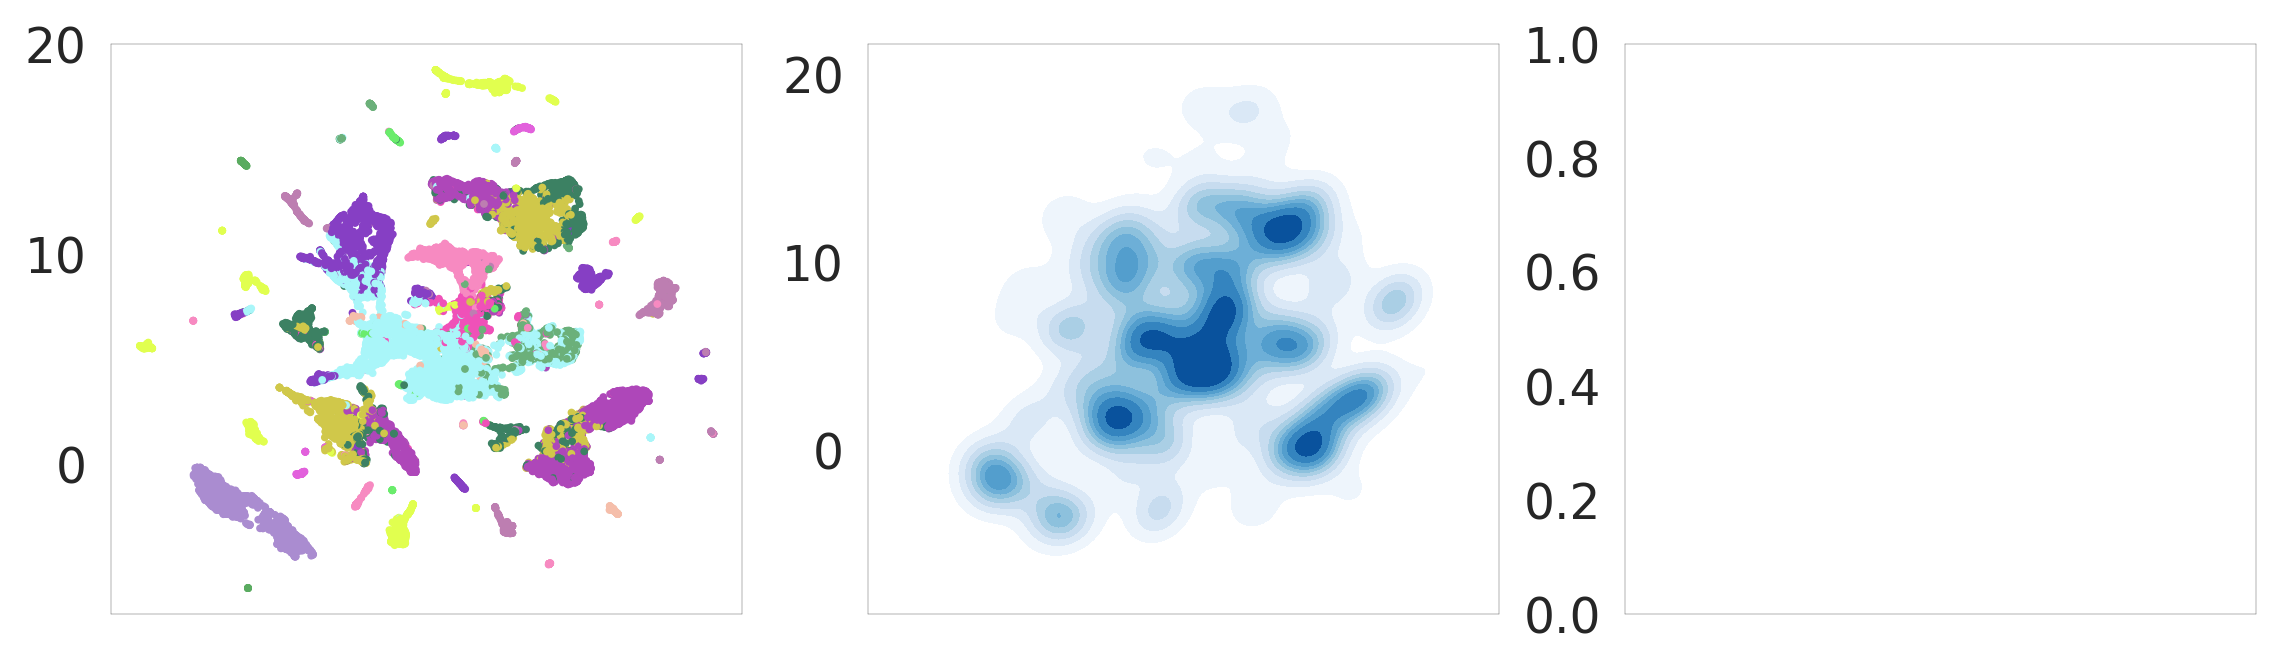

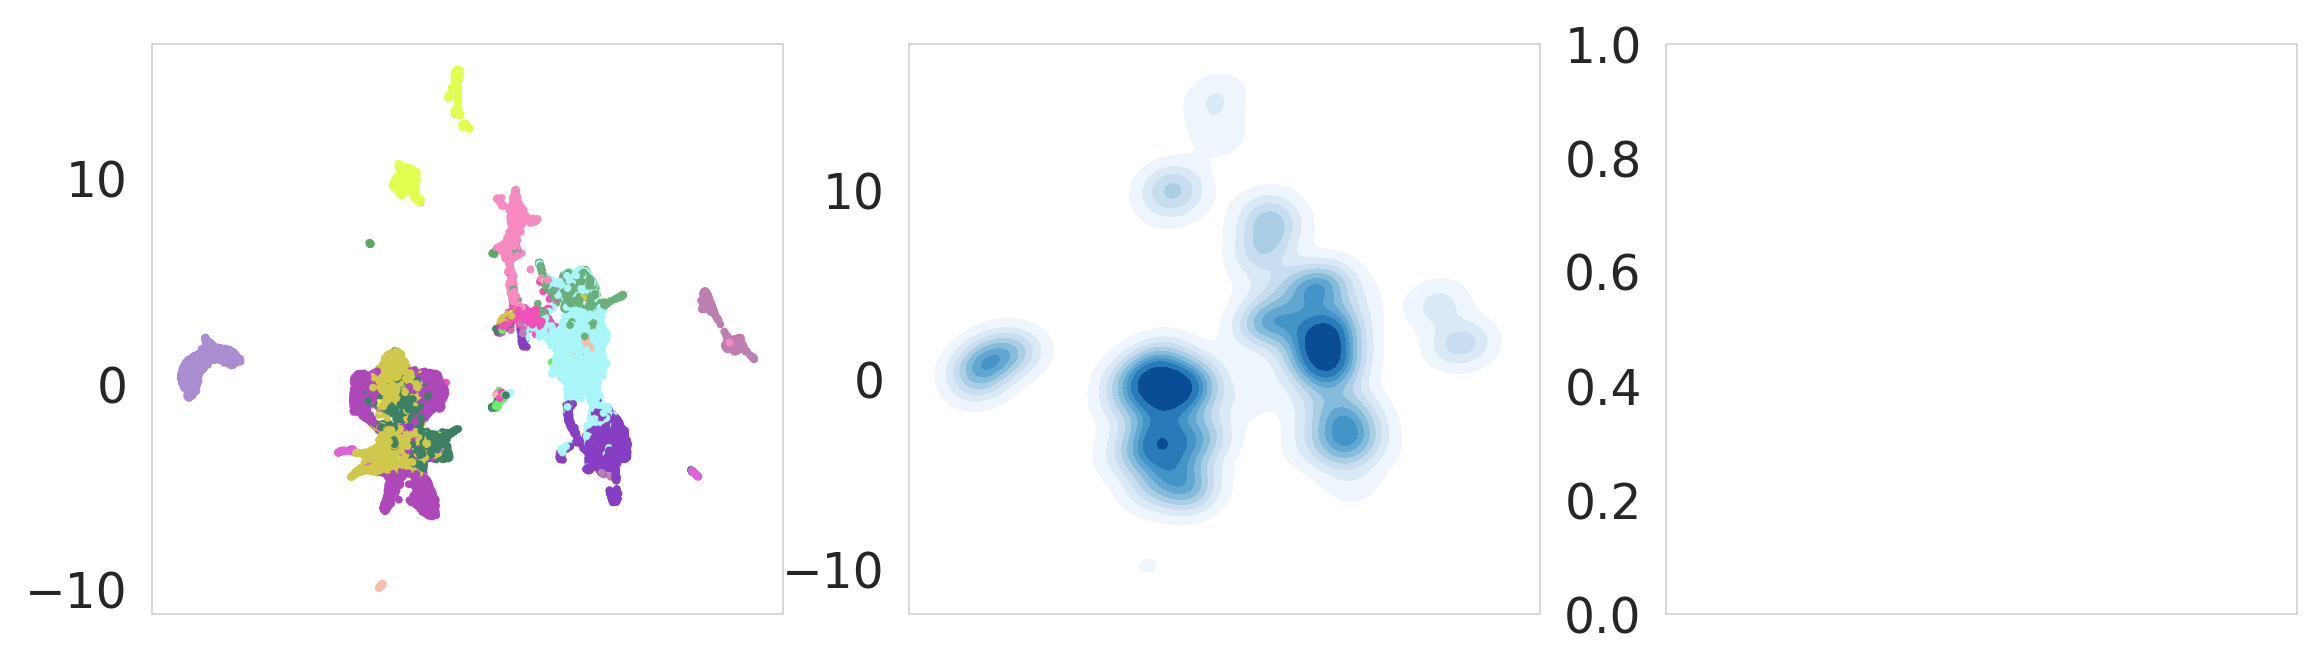

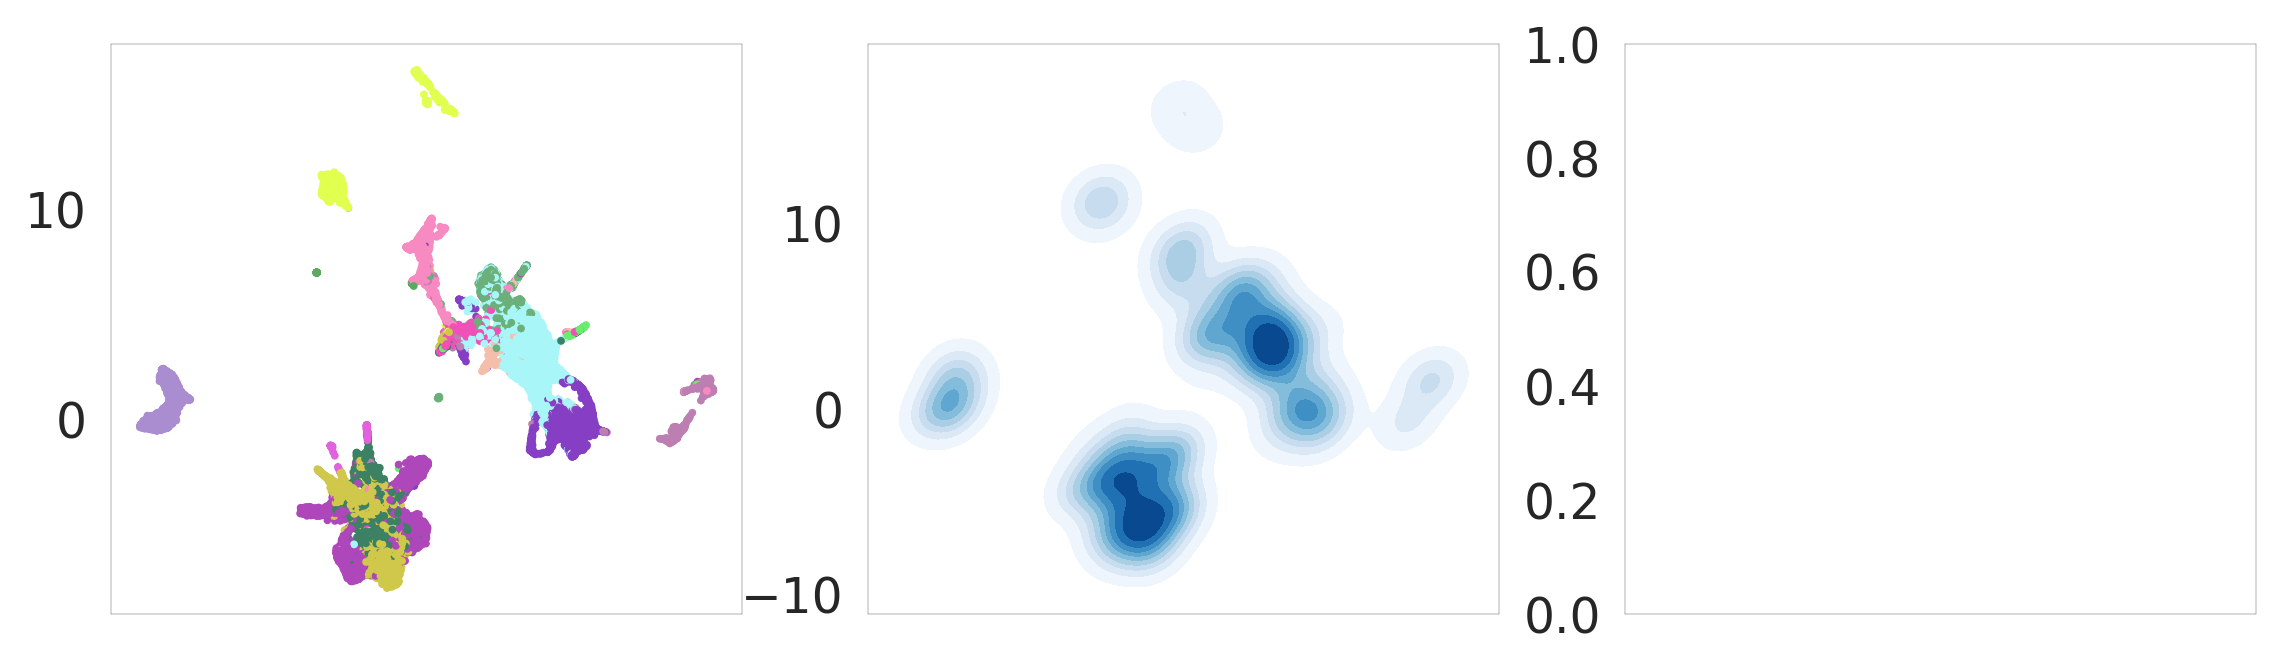

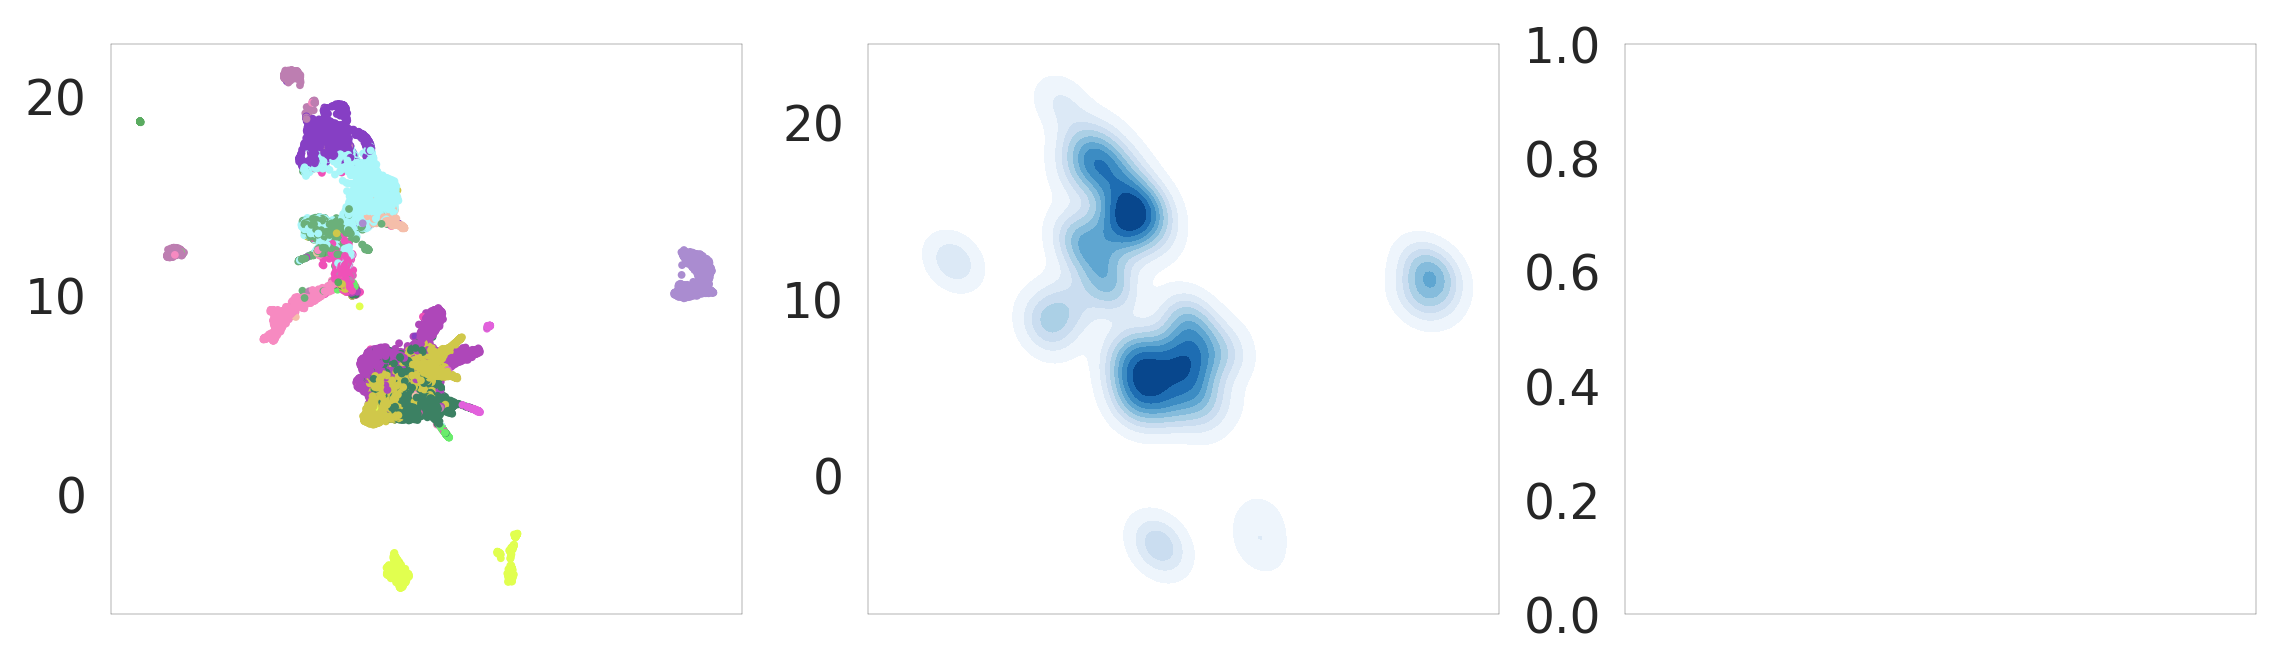

In [ ]:
sns.set_style("white")
for i in pcaUMAP:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(11,3))
  sns.scatterplot(x=i[:,0],y=i[:,1],hue=fullNames,palette=cdict,ax=ax1,legend=False,s=5,linewidth=0)
  sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1],cmap='Blues',ax=ax2,shade=True) #shade=True
  #sns.kdeplot(x=i[labs[1]=='ExUt',0], y=i[labs[1]=='ExUt',1],  cmap='Reds',ax=ax3,shade=True)
  #sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1], cmap="Blues", shade=True,ax=ax2) #bw_adjust=.5

  ax1.xaxis.set_ticklabels([])
  ax2.xaxis.set_ticklabels([])
  ax3.xaxis.set_ticklabels([])
  plt.show()

In [ ]:
toUseAdata = exAdata
count_mat_orig = toUseAdata.obsm['log']
scaled_mat_orig = toUseAdata.X

In [ ]:
labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

fullNames = labs[0]

In [ ]:
#PCA 
tsvd = TruncatedSVD(n_components=50)
x_pca = tsvd.fit_transform(scaled_mat_orig)

pcaUMAP = []
for n in [5,30,50,350]:
  reducer = umap.UMAP(n_components = ndims, random_state = state+1, n_neighbors=n)
  pcaUMAP += [reducer.fit_transform(x_pca)]


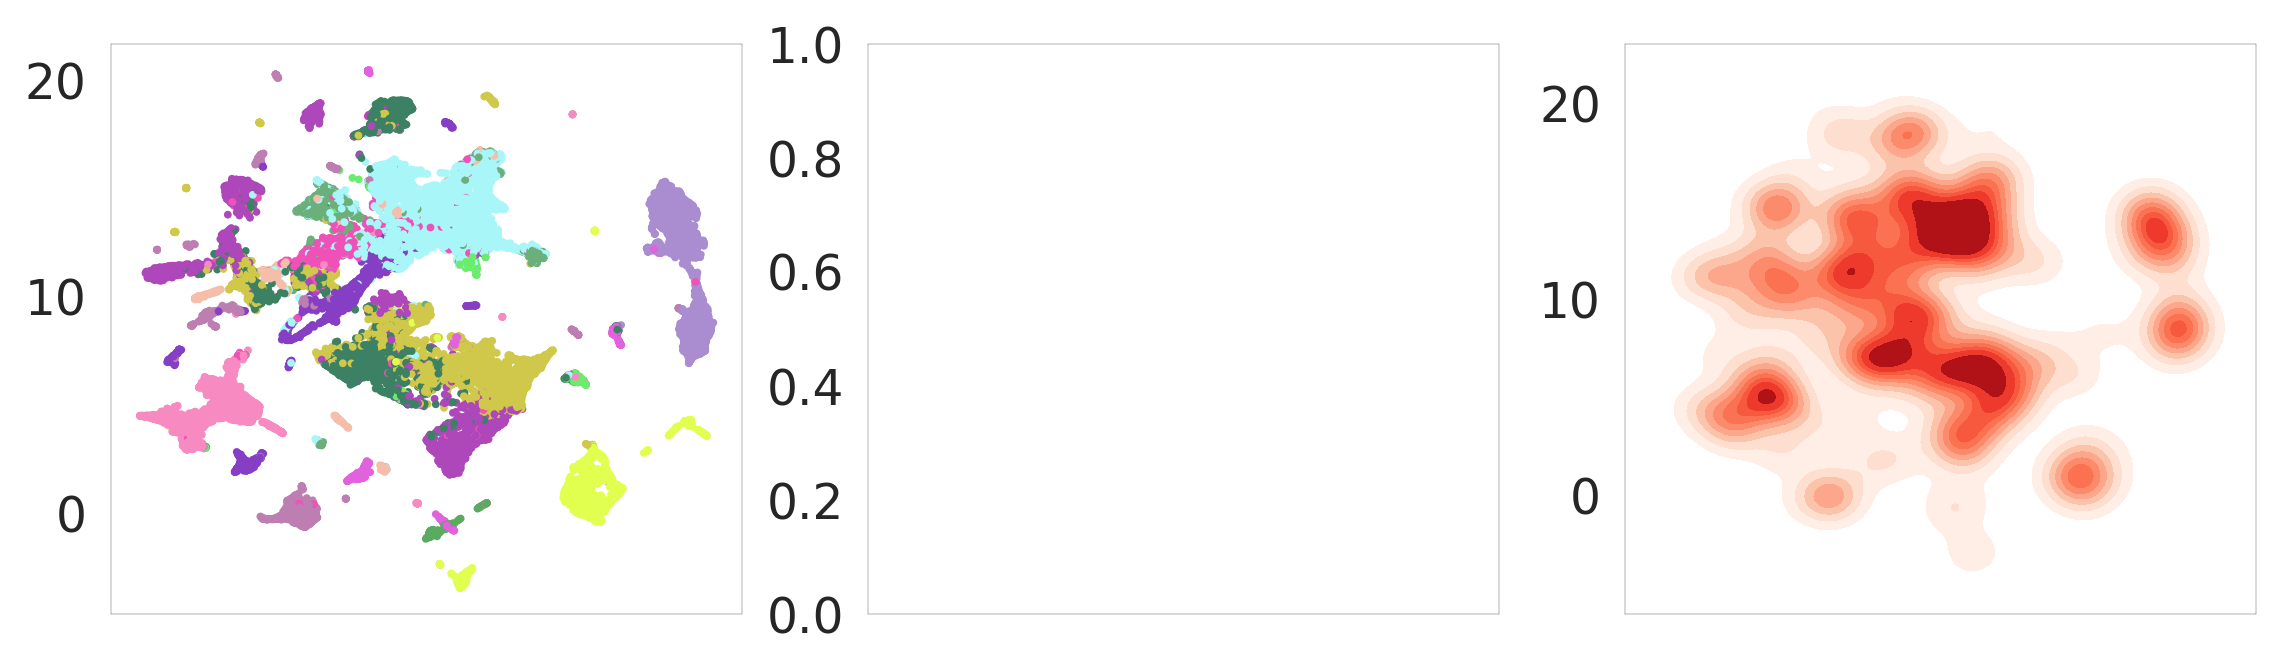

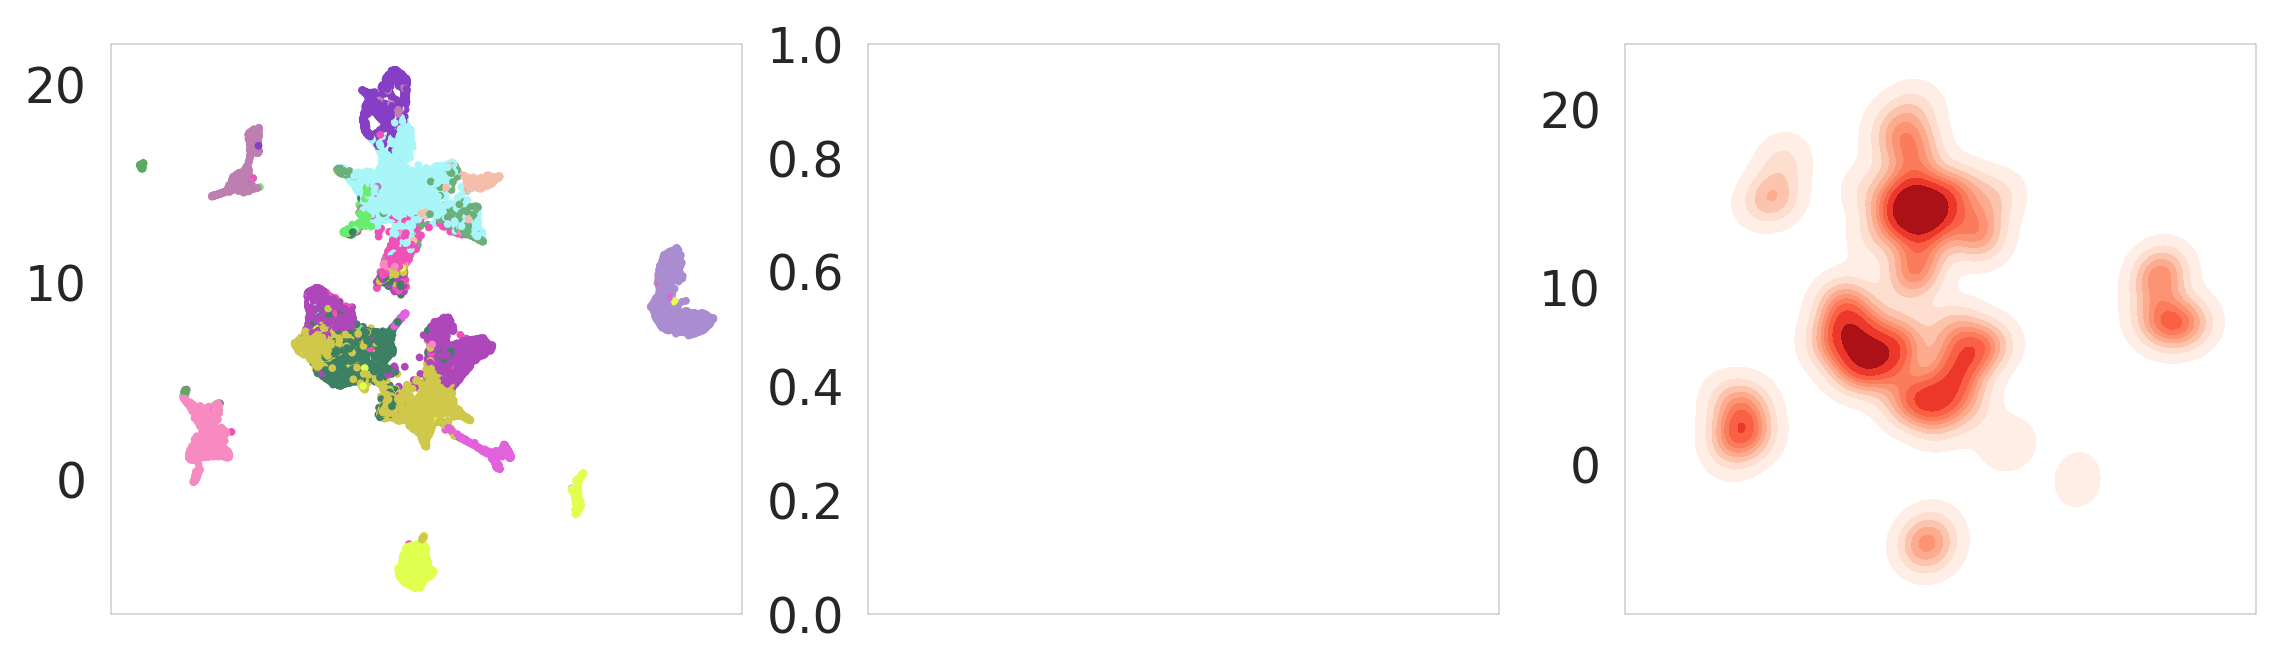

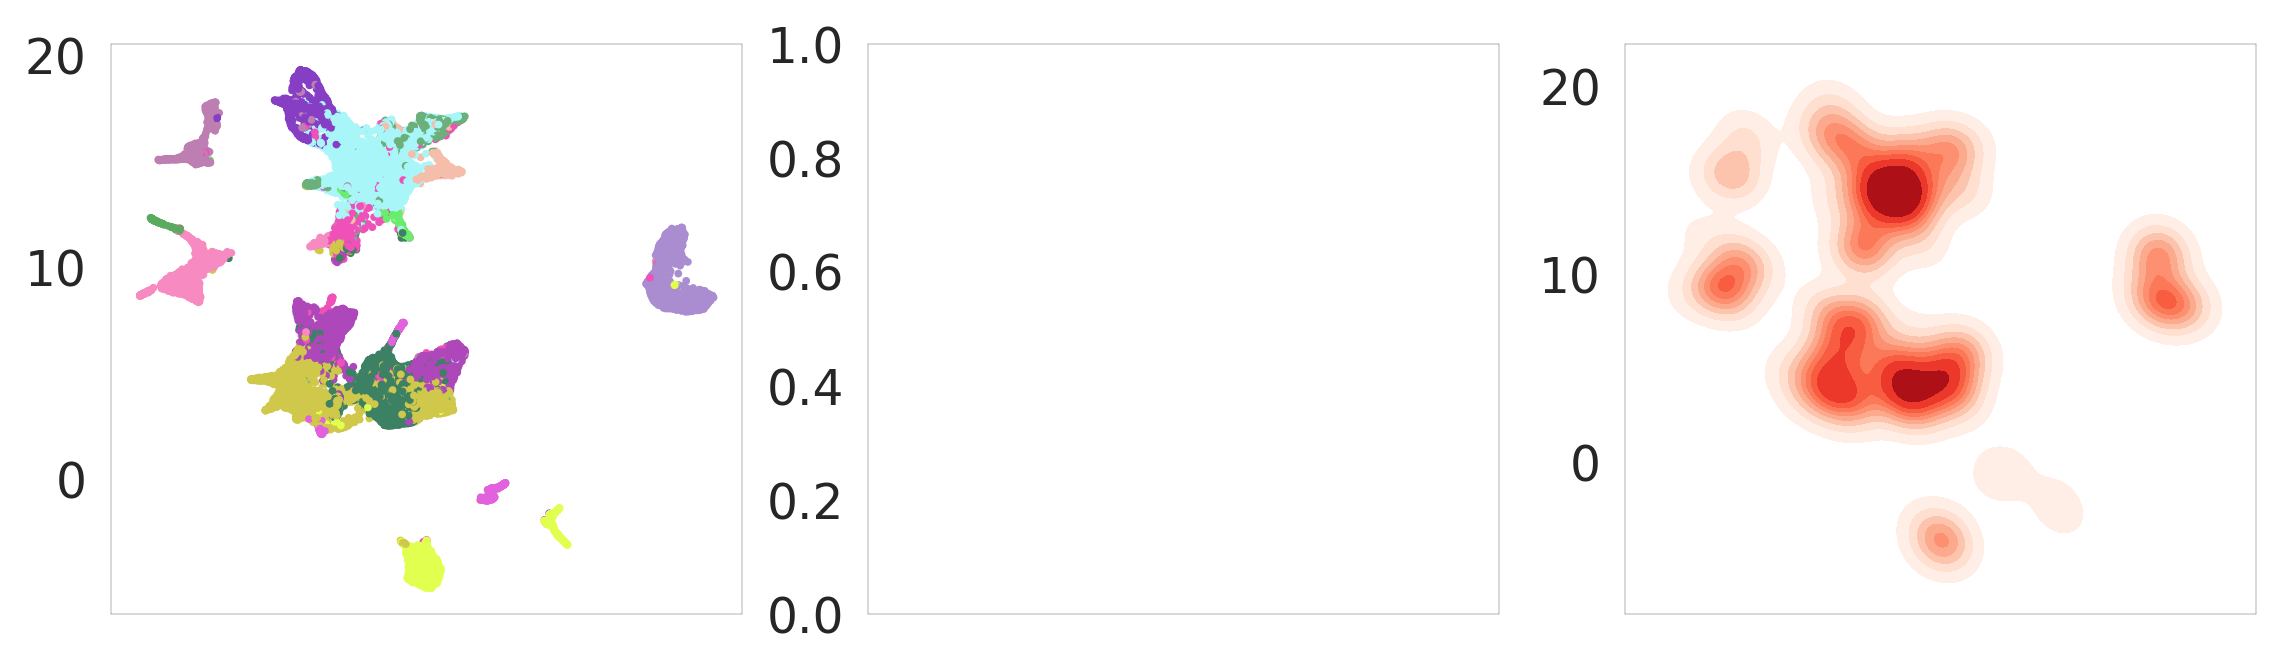

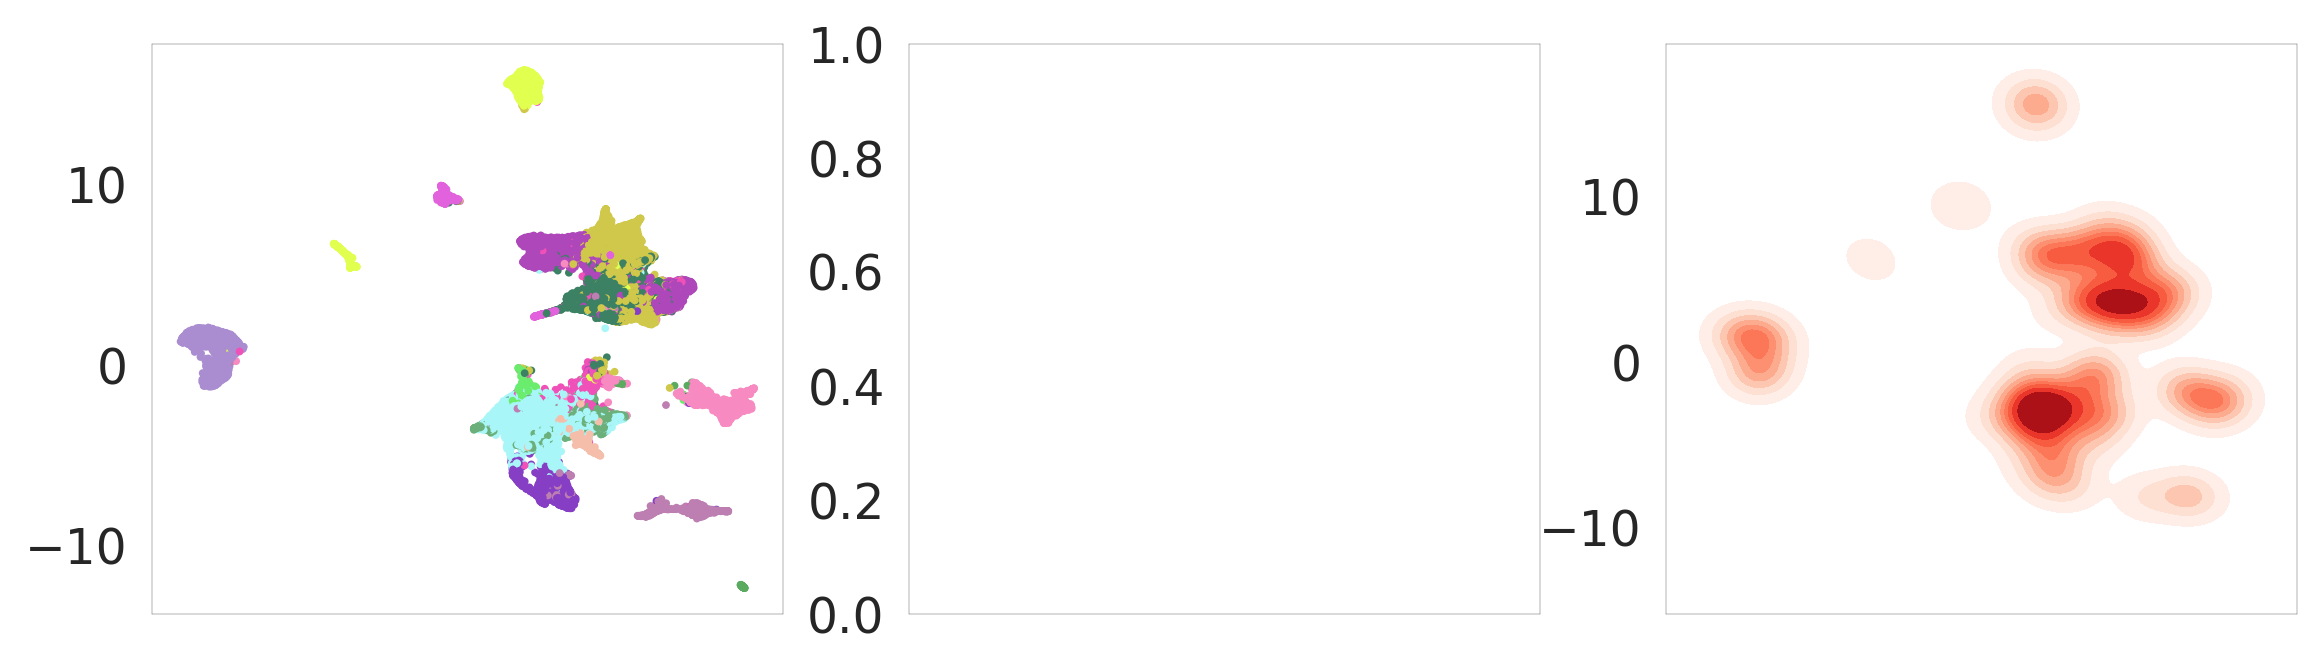

In [ ]:
sns.set_style("white")
for i in pcaUMAP:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(11,3))
  sns.scatterplot(x=i[:,0],y=i[:,1],hue=fullNames,palette=cdict,ax=ax1,legend=False,s=5,linewidth=0)
  #sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1],cmap='Blues',ax=ax2,shade=True) #shade=True
  sns.kdeplot(x=i[labs[1]=='ExUt',0], y=i[labs[1]=='ExUt',1],  cmap='Reds',ax=ax3,shade=True)
  #sns.kdeplot(x=i[labs[1]=='InUt',0], y=i[labs[1]=='InUt',1], cmap="Blues", shade=True,ax=ax2) #bw_adjust=.5

  ax1.xaxis.set_ticklabels([])
  ax2.xaxis.set_ticklabels([])
  ax3.xaxis.set_ticklabels([])
  plt.show()